### 기본셋팅

In [13]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='Malgun Gothic')
import datasets
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
def load_preprocessing(file_name):
    # 데이터불러오기
    directory = './data/'
    df = pd.read_csv(directory+ file_name)

    display(df.head(3))
    try:
        # 공통컬럼
        df['client_event_time'] = pd.to_datetime(df['client_event_time']) # utc 0 기준이므로 +9시간 추가해줘서 대한민국에 맞춘다. (적용 완료)
                                                                                                      # 타 국가에 대해 살펴볼 경우에는 시간대를 해당국가에 맞게 지정해줘야한다.
        # 시간대 확인
        print(f"\n\n시간최소 : {df['client_event_time'].min()} , 시간최대 :{df['client_event_time'].max()}\n")
    except:
        pass
    
    # 기초 정보량 확인
    isn = df.isnull().sum()
    isn_ratio = (df.isnull().sum() / df.shape[0] * 100).round(1).astype('int').astype('str') + '%'
    unq = df.nunique()
    top_frq = df.describe(include='O').loc['top']

    
    pre_df = pd.concat([isn,isn_ratio,unq,top_frq],axis=1)
    pre_df.columns =['결측치','결측치(%)','유니크값','최빈값']
    pre_df.index.name = 'shape : ' + str(df.shape)
    display(pre_df)
    return df

In [15]:
# 데이터 시간범위 설정하기
def time_limit(df):
    df['client_event_time'] = pd.to_datetime(df['client_event_time'])
    df = df.loc[(df['client_event_time'].dt.year == 2022) | (df['client_event_time'].dt.year == 2023)]
    
    return df

In [16]:
def data_managing(df):
    # 제거할 컬럼 목록
    columns_to_drop = ['device_carrier', 'platform', 'os_version']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # 크롤링 데이터 제거
    if 'os_name' in (df.columns):
        df = df.loc[df['os_name'] != 'Chrome Headless']
    

    # 버튼 네이밍
    if 'button_name' in (df.columns):
        df = df.rename(columns={'button_name':'button_name_type_a', 'button.name':'button_name_type_b'})

    # . -> _ 로 변경
    df.columns = df.columns.str.replace('.', '_')
  
    # 타임
    if 'client_event_time' in (df.columns):
        df['client_event_time'] = pd.to_datetime(df['client_event_time']) # + datetime.timedelta(hours = 9)
        df = time_limit(df)
    
    # reset_index
    df = df.reset_index(drop=True)
    return df

In [17]:
def duplicated_data_processing(df):
    # datetime 으로 형변환 확인
    if df['client_event_time'].dtype == '<M8[ns]':
        pass
    else:
        df['client_event_time'] = pd.to_datetime(df['client_event_time'])
    
    df['client_event_time_m'] = df['client_event_time'].dt.strftime('%Y-%m-%d %H:%M')
    
    columns = df.columns
    # 컬럼명 확인 후, lesson_id -> content_id 가 순서로 존재하는지 체크하여 초단위 중복 확인 및 제거
    if 'lesson_id' in columns:
        df = df.sort_values(by=['client_event_time_m','user_id','lesson_id'],ascending=True).drop_duplicates(subset=['user_id','lesson_id','client_event_time_m'],keep='first')
        print('lesson_id 대해서 초단위 중복 제거')
    elif 'content_id' in columns:
        df = df.sort_values(by=['client_event_time_m','user_id','content_id'],ascending=True).drop_duplicates(subset=['user_id','content_id','client_event_time_m'],keep='first')
        print('content_id에 대해서 초단위 중복 제거')
    else:
        print('lesson_id 혹은 content_id 컬럼이 없습니다.')
    df = df.drop('client_event_time_m',axis=1)
    return df
    

#### 데이터 전처리

In [18]:
# data 폴더의 csv 파일 목록 불러오기
csv_files = [f for f in os.listdir('./data') if f.endswith('.csv')]
print(csv_files)

# 데이터 전체 매니징
for file in csv_files:
    df = load_preprocessing(file)
    df = data_managing(df)
    if file == 'start.free_trial.csv':
        user_ids_with_both_trials = df.groupby('user_id')['trial_type'].nunique()
        
        # type A, type B 모두 이용한 유저 제거
        user_ids_with_both_trials = user_ids_with_both_trials[user_ids_with_both_trials > 1].index.tolist()
        df = df.loc[~df['user_id'].isin(user_ids_with_both_trials)]
        
        del user_ids_with_both_trials
    #저장
    # df.to_csv('./data/' + file, encoding='UTF-8', index=False)

['click.cancel_plan_button.csv', 'click.content_page_more_review_button.csv', 'click.content_page_start_content_button.csv', 'click.lesson_page_related_question_box.csv', 'complete.lesson.csv', 'complete.signup.csv', 'complete.subscription.csv', 'end.content.csv', 'enter.content_page.csv', 'enter.lesson_page.csv', 'enter.main_page.csv', 'enter.payment_page.csv', 'enter.signup_page.csv', 'renew.subscription.csv', 'resubscribe.subscription.csv', 'start.content.csv', 'start.free_trial.csv', 'user_start_end_complete.csv']


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Daegu,2023-04-10 23:57:48.556,South Korea,Windows,Windows,click.cancel_plan_button,Korean,Chrome,9e59ecf9a8fbe9051bd0d54f4b702f30
1,Seoul,2023-03-12 17:26:16.224,South Korea,Apple iPad,Apple iPad,click.cancel_plan_button,English,Mobile Safari,4ed4d8f12c45504a148bfff0f2e9466e
2,Uijeongbu-si,2023-03-12 17:23:04.955,South Korea,Windows,Windows,click.cancel_plan_button,Korean,Chrome,b6a1bba3cc4139d7dc821561319221e6




시간최소 : 2022-01-01 11:24:46.052000 , 시간최대 :2023-12-31 23:58:18.895000



,결측치,결측치(%),유니크값,최빈값
"shape : (17881, 9)",,,,
city,152,0%,476,Seoul
client_event_time,0,0%,17881,NaN
country,2,0%,44,South Korea
device_family,0,0%,37,Windows
device_type,326,1%,110,Windows
event_type,0,0%,1,click.cancel_plan_button
language,0,0%,9,Korean
os_name,0,0%,19,Chrome
user_id,1030,5%,14641,9b48974f776b88ab303a43cc4db09d66


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id
0,Seo-gu,2023-04-10 23:10:01.402,South Korea,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,558fe7e8c06b8505f11b33d76f076e56,a1eeebeb6c307641b75b94a2a1d5b9aa
1,London,2023-01-25 06:37:43.417,United Kingdom,Windows,Windows,click.content_page_more_review_button,Korean,Whale,e48956538e4df690a5d12adf1e6f2ee3,f491517f4737a60d661cd1fcacc702c0
2,Eunpyeong-gu,2023-01-31 23:44:16.897,South Korea,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,e745da89019e303b122bfceac0521a8f,9aa7628a347707fb155943041e2cb524




시간최소 : 2022-01-01 10:34:02.834000 , 시간최대 :2023-12-31 22:03:46.531000



,결측치,결측치(%),유니크값,최빈값
"shape : (44516, 10)",,,,
city,169,0%,275,Hwaseong-si
client_event_time,0,0%,44513,NaN
country,18,0%,21,South Korea
device_family,0,0%,20,Mac
device_type,52,0%,82,Mac
event_type,0,0%,1,click.content_page_more_review_button
language,0,0%,7,Korean
os_name,0,0%,17,Chrome
user_id,33817,76%,3194,d2c7120aabd4ece896035f58b763a2dd


C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\2608666057.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(directory+ file_name)


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,button_name_type_b,button_name_type_a
0,Daejeon,2023-04-06 06:14:38.432,South Korea,Windows,Windows,click.content_page_start_content_button,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,콘텐츠 구독하기,NaN
1,Seongnam-si,2023-04-10 23:57:20.033,South Korea,Windows,Windows,click.content_page_start_content_button,Korean,Edge,f7155af01d277f11b1c7d05cf772c686,18992b667be06d6f29ba0008f99d9745,콘텐츠 이어보기,NaN
2,Yangp'yong,2023-04-10 23:28:29.515,South Korea,Windows,Windows,click.content_page_start_content_button,Korean,Chrome,1b05f9fe82b80771323caa1cd5683143,dfbdae782996c25daed7517b8835f3aa,콘텐츠 이어보기,NaN




시간최소 : 2022-01-01 00:50:50.923000 , 시간최대 :2023-12-31 23:54:52.592000



,결측치,결측치(%),유니크값,최빈값
"shape : (172880, 12)",,,,
city,3474,2%,842,Seoul
client_event_time,0,0%,172500,NaN
country,1416,0%,58,South Korea
device_family,0,0%,144,Windows
device_type,1330,0%,232,Windows
event_type,0,0%,1,click.content_page_start_content_button
language,0,0%,18,Korean
os_name,0,0%,25,Chrome
user_id,44542,25%,35106,adebe7a80d656ce4b81b94a83bac0962


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,question_id,content_id,lesson_id
0,Dong-gu,2023-04-06 06:51:48.377,South Korea,Samsung Phone,Samsung Galaxy S21 5G,click.lesson_page_related_question_box,English,Chrome,117f95e12266dcf8f911ae39ff55a800,c654f9825245640595af9b8aecb150aa,c269eb6df3a374b464f7c18f12fa398f,e7dbf75457e67ef644d4ae1981b9e01b
1,Dong-gu,2023-04-06 06:52:21.689,South Korea,Samsung Phone,Samsung Galaxy S21 5G,click.lesson_page_related_question_box,English,Chrome,117f95e12266dcf8f911ae39ff55a800,898fb79fc740dc8705b52fb32521d5d5,c269eb6df3a374b464f7c18f12fa398f,e7dbf75457e67ef644d4ae1981b9e01b
2,Dong-gu,2023-04-06 06:52:42.481,South Korea,Samsung Phone,Samsung Galaxy S21 5G,click.lesson_page_related_question_box,English,Chrome,117f95e12266dcf8f911ae39ff55a800,9fb80c124d57fd31494738e0af5437a3,c269eb6df3a374b464f7c18f12fa398f,e7dbf75457e67ef644d4ae1981b9e01b




시간최소 : 2022-01-01 02:27:46.469000 , 시간최대 :2023-12-31 23:55:54.637000



,결측치,결측치(%),유니크값,최빈값
"shape : (1378890, 12)",,,,
city,23461,1%,965,Seoul
client_event_time,0,0%,1378760,NaN
country,14891,1%,54,South Korea
device_family,1,0%,73,Windows
device_type,6332,0%,165,Windows
event_type,0,0%,1,click.lesson_page_related_question_box
language,0,0%,18,Korean
os_name,1,0%,22,Chrome
user_id,52854,3%,40403,9089b878e92400b50184ec178819fcf6


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,lesson_id
0,Wonju,2023-04-06 06:55:51.836,South Korea,Windows,Windows,complete.lesson,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,d360d68b65fd3e0eafb7982386d75fd9
1,Daejeon,2023-04-06 06:19:01.243,South Korea,Windows,Windows,complete.lesson,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,7e0f6aae886368ef9fa97007a8e9f7ac
2,Daejeon,2023-04-06 06:20:27.939,South Korea,Windows,Windows,complete.lesson,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,d1e93c9dc08267efab31849bc6083854




시간최소 : 2022-01-01 09:00:01.181000 , 시간최대 :2023-12-31 23:59:51.635000



,결측치,결측치(%),유니크값,최빈값
"shape : (5404242, 11)",,,,
city,189548,3%,1192,Seoul
client_event_time,0,0%,5403951,NaN
country,148229,2%,67,South Korea
device_family,52904,1%,111,Windows
device_type,80678,1%,204,Windows
event_type,0,0%,1,complete.lesson
language,52883,1%,16,Korean
os_name,53160,1%,23,Chrome
user_id,0,0%,49670,f59e4102149edeb73cb33ccecf95dcd9


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,type
0,NaN,2023-04-06 06:33:26.068,NaN,NaN,NaN,complete.signup,NaN,NaN,74d17c27a41656e7788b0c81d9f76cda,kakao
1,NaN,2023-04-06 06:45:18.672,NaN,NaN,NaN,complete.signup,NaN,NaN,06b6868000a5d576180aca47896d6cce,kakao
2,Seo-gu,2023-04-10 23:47:56.424,South Korea,Windows,Windows,complete.signup,Korean,Chrome,e131c319972bd580146c5a2faba26613,kakao




시간최소 : 2022-01-01 09:06:31.232000 , 시간최대 :2023-12-31 23:41:01.654000



,결측치,결측치(%),유니크값,최빈값
"shape : (145082, 10)",,,,
city,100308,69%,543,Seoul
client_event_time,0,0%,145081,NaN
country,99326,68%,56,South Korea
device_family,99315,68%,67,Windows
device_type,100423,69%,167,Windows
event_type,0,0%,1,complete.signup
language,99315,68%,16,Korean
os_name,99337,68%,19,Chrome
user_id,0,0%,145082,4252b7d6d08c1ba797ec2f5d0b244963


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,paid_amount,coupon_discount_amount,pg_type
0,Nowon-gu,2023-04-06 06:40:04.000,South Korea,Windows,Windows,complete.subscription,Korean,Edge,1116a2ae90ca6b06f85feba27ad51ef0,15920,15920,0,NaN
1,Seoul,2023-04-10 23:20:03.008,South Korea,Apple iPhone,Apple iPhone,complete.subscription,Korean,Mobile Safari,c0f5678df8967163e6e2c464ed006791,131600,131600,0,NaN
2,Yangsan,2023-03-12 17:46:14.026,South Korea,Windows,Windows,complete.subscription,Korean,Chrome,79421b5d038205ad7adbb1e2c3b89741,131600,119756,11844,NaN




시간최소 : 2022-01-01 15:17:24.513000 , 시간최대 :2023-12-31 23:59:39.461000



,결측치,결측치(%),유니크값,최빈값
"shape : (14283, 13)",,,,
city,531,3%,389,Seoul
client_event_time,0,0%,14281,NaN
country,382,2%,37,South Korea
device_family,374,2%,34,Windows
device_type,524,3%,121,Windows
event_type,0,0%,1,complete.subscription
language,374,2%,9,Korean
os_name,380,2%,18,Chrome
user_id,0,0%,13875,3767d4c7a827422fccf61d45ae889669


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id
0,Yokohama,2023-04-10 23:02:10.600,Japan,Windows,Windows,end.content,Japanese,Chrome,3fd801c6192296cf7b85efc01bd547b9,a914987711c7e2db9fd4bff7555ec87c
1,Seoul,2023-04-10 23:21:26.466,South Korea,Windows,Windows,end.content,Korean,Chrome,85a332649d34bc7b5ebdec7660b1d57d,f64c475280676531a31f2f8e0648599c
2,Seongbuk-gu,2023-04-10 23:37:04.440,South Korea,Windows,Windows,end.content,Korean,Chrome,2bf8cb1d9c5d4556f5165c2aaf804f2e,7fef928cdccef0185dfb931ef59b37d7




시간최소 : 2022-01-01 10:29:42.752000 , 시간최대 :2023-12-31 23:55:36.331000



,결측치,결측치(%),유니크값,최빈값
"shape : (120561, 10)",,,,
city,4298,3%,711,Seoul
client_event_time,0,0%,120559,NaN
country,3396,2%,48,South Korea
device_family,1187,1%,45,Windows
device_type,1710,1%,133,Windows
event_type,0,0%,1,end.content
language,1186,1%,13,Korean
os_name,1191,1%,20,Chrome
user_id,0,0%,29230,5adda05deaed721c6765ca368c80f09b


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id
0,Seoul,2023-04-06 06:40:35.740,South Korea,Apple iPhone,Apple iPhone,enter.content_page,Korean,Chrome,d57aba7b4527e71b96135deaaec57def,220ce7873b8895d0c81c37600b5bd1e7
1,Hwaseong-si,2023-04-06 06:01:59.950,South Korea,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.content_page,Korean,Chrome,NaN,ecde9a1b01763f791c3a185d53b5f394
2,Daejeon,2023-04-06 06:13:12.038,South Korea,Windows,Windows,enter.content_page,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,b8d4ec0133e5ce485055bfd69cd28abd




시간최소 : 2022-01-01 00:50:10.598000 , 시간최대 :2023-12-31 23:59:07.849000



,결측치,결측치(%),유니크값,최빈값
"shape : (1912090, 10)",,,,
city,30495,1%,1866,Seoul
client_event_time,0,0%,1911682,NaN
country,7570,0%,111,South Korea
device_family,639,0%,290,Windows
device_type,23623,1%,357,Windows
event_type,0,0%,1,enter.content_page
language,0,0%,35,Korean
os_name,149,0%,29,Chrome
user_id,463329,24%,72695,4f74b6e2f650f4c8db87579e44f5b7d6


C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\2608666057.py:4: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(directory+ file_name)


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,is_trial,lesson_id,is_free_trial
0,Wonju,2023-04-06 06:46:04.333,South Korea,Windows,Windows,enter.lesson_page,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,d360d68b65fd3e0eafb7982386d75fd9,NaN
1,Wonju,2023-04-06 06:55:50.787,South Korea,Windows,Windows,enter.lesson_page,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,d360d68b65fd3e0eafb7982386d75fd9,NaN
2,Wonju,2023-04-06 06:55:55.684,South Korea,Windows,Windows,enter.lesson_page,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,770740696ab1809d6b50d4013b64a75c,NaN




시간최소 : 2022-01-01 00:50:53.603000 , 시간최대 :2023-12-31 23:59:51.006000



,결측치,결측치(%),유니크값,최빈값
"shape : (21028196, 13)",,,,
city,539967,2%,1646,Seoul
client_event_time,0,0%,21021059,NaN
country,358426,1%,88,South Korea
device_family,6482,0%,193,Windows
device_type,141794,0%,276,Windows
event_type,0,0%,1,enter.lesson_page
language,0,0%,25,Korean
os_name,417,0%,26,Chrome
user_id,1537886,7%,113916,d21dc741fde11ffb6768d8bdb3547398


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Seongnam-si,2023-04-06 06:55:06.140,South Korea,Samsung Phone,Samsung Galaxy S21 5G,enter.main_page,Korean,Whale,NaN
1,Dongdaemun-gu,2023-04-06 06:04:28.967,South Korea,Mac,Mac,enter.main_page,Korean,Chrome,b2b31f00b82edc6419b25324a7ae41a4
2,Hwaseong-si,2023-04-06 06:01:31.258,South Korea,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,NaN




시간최소 : 2022-01-01 09:02:20.959000 , 시간최대 :2023-12-15 11:46:11.182000



,결측치,결측치(%),유니크값,최빈값
"shape : (2130725, 9)",,,,
city,55062,2%,3422,Seoul
client_event_time,0,0%,2129372,NaN
country,1868,0%,172,South Korea
device_family,2813,0%,677,Windows
device_type,60050,2%,529,Windows
event_type,0,0%,1,enter.main_page
language,0,0%,62,Korean
os_name,2304,0%,40,Chrome
user_id,1608222,75%,75365,0555a42d8840da988b921cddd3b50019


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Seoul,2023-04-06 06:31:27.602,South Korea,Samsung Phone,Samsung Galaxy A51 5G,enter.payment_page,Korean,Chrome,8ee58bcaa05b234cdbf84167c0983385
1,Wonju,2023-04-06 06:33:30.699,South Korea,Windows,Windows,enter.payment_page,Korean,Chrome,74d17c27a41656e7788b0c81d9f76cda
2,Daejeon,2023-04-06 06:05:28.337,South Korea,Windows,Windows,enter.payment_page,Korean,Edge,62cfa08370da60b8db4495baaff62806




시간최소 : 2022-11-03 11:39:46.400000 , 시간최대 :2023-12-10 23:56:01.475000



,결측치,결측치(%),유니크값,최빈값
"shape : (165061, 9)",,,,
city,2699,1%,778,Seoul
client_event_time,0,0%,165027,NaN
country,162,0%,69,South Korea
device_family,1,0%,131,Windows
device_type,5995,3%,229,Windows
event_type,0,0%,1,enter.payment_page
language,0,0%,18,Korean
os_name,0,0%,22,Chrome
user_id,6227,3%,63918,233094e3798cb9f681d9d1466e276ed8


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Seoul,2023-04-06 06:30:42.557,South Korea,Samsung Phone,Samsung Galaxy A51 5G,enter.signup_page,Korean,Chrome,NaN
1,Seoul,2023-04-06 06:37:41.467,South Korea,Samsung SM-S916N,NaN,enter.signup_page,Korean,Chrome,NaN
2,Seoul,2023-04-06 06:05:53.237,South Korea,Apple iPhone,Apple iPhone,enter.signup_page,Korean,Mobile Safari,NaN




시간최소 : 2022-01-01 00:26:57.049000 , 시간최대 :2023-12-31 23:59:28.692000



,결측치,결측치(%),유니크값,최빈값
"shape : (596273, 9)",,,,
city,15682,2%,2470,Seoul
client_event_time,0,0%,596172,NaN
country,514,0%,180,South Korea
device_family,82,0%,848,Windows
device_type,29419,4%,552,Windows
event_type,0,0%,1,enter.signup_page
language,0,0%,59,Korean
os_name,75,0%,33,Chrome
user_id,596273,100%,0,NaN


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,paid_amount,coupon_discount_amount,pg_type
0,Nam-gu,2022-09-08 12:05:02.068,South Korea,Windows,Windows,renew.subscription,Korean,Edge,6ddea3af2eaae869861c1190dcc9d4a3,15920,15920,0,NaN
1,Nam-gu,2022-09-08 12:40:02.050,South Korea,Windows,Windows,renew.subscription,Korean,Chrome,c2d47034960fdff5df495822ff66fbc1,15920,15920,0,NaN
2,Dongjak-gu,2022-09-08 12:49:00.829,South Korea,Windows,Windows,renew.subscription,Korean,Chrome,de91f1226dd938990fefc79545daf468,42960,40812,2148,NaN




시간최소 : 2022-09-08 12:05:02.068000 , 시간최대 :2023-12-31 23:50:02.215000



,결측치,결측치(%),유니크값,최빈값
"shape : (15944, 13)",,,,
city,370,2%,421,Seoul
client_event_time,0,0%,15939,NaN
country,289,1%,39,South Korea
device_family,288,1%,26,Windows
device_type,461,2%,99,Windows
event_type,0,0%,1,renew.subscription
language,288,1%,9,Korean
os_name,291,1%,16,Chrome
user_id,0,0%,7498,9f12c110740a42edb3c837d2562de2e9


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,paid_amount,coupon_discount_amount,pg_type
0,Daejeon,2023-04-06 06:11:45.525,South Korea,Windows,Windows,resubscribe.subscription,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,15920,15920,0,NaN
1,Seoul,2023-06-30 18:59:56.848,South Korea,Samsung Phone,Samsung Galaxy S22+,resubscribe.subscription,Korean,Chrome WebView,68831c27e47f0e8f04ba809baeec218e,15920,15920,0,NaN
2,Nowon-gu,2023-06-13 15:20:22.524,South Korea,Windows,Windows,resubscribe.subscription,Korean,Chrome,4e7568cb7db01f8386614ec2c6c961cd,15920,15920,0,NaN




시간최소 : 2022-09-08 14:42:29.912000 , 시간최대 :2023-12-31 23:57:02.034000



,결측치,결측치(%),유니크값,최빈값
"shape : (789, 13)",,,,
city,16,2%,150,Seoul
client_event_time,0,0%,789,NaN
country,7,0%,12,South Korea
device_family,7,0%,13,Windows
device_type,18,2%,33,Windows
event_type,0,0%,1,resubscribe.subscription
language,7,0%,3,Korean
os_name,7,0%,13,Chrome
user_id,0,0%,759,688a59aa0378a80cf660175bd6d2e226


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,content_difficulty
0,Daejeon,2023-04-06 06:14:39.906,South Korea,Windows,Windows,start.content,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,beginner
1,Seoul,2023-04-06 06:50:19.674,South Korea,Mac,Mac,start.content,Korean,Safari,06b6868000a5d576180aca47896d6cce,f4be1a0fe0e301b03115591777fddf29,beginner
2,Seoul,2023-04-10 23:06:26.585,South Korea,Mac,Mac,start.content,Korean,Whale,7b2ff3116db46b5e4326d49c7b027631,61b6463287573f00de13a930805a52d6,beginner




시간최소 : 2022-08-17 16:11:12.230000 , 시간최대 :2023-12-31 23:57:28.452000



,결측치,결측치(%),유니크값,최빈값
"shape : (124869, 11)",,,,
city,3887,3%,723,Seoul
client_event_time,0,0%,124869,NaN
country,2873,2%,57,South Korea
device_family,2215,1%,91,Windows
device_type,4835,3%,199,Windows
event_type,0,0%,1,start.content
language,2213,1%,13,Korean
os_name,2234,1%,23,Chrome
user_id,0,0%,42784,f59e4102149edeb73cb33ccecf95dcd9


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,plan_type,trial_type
0,Seoul,2023-04-06 06:49:36.156,South Korea,Mac,Mac,start.free_trial,Korean,Safari,06b6868000a5d576180aca47896d6cce,15920.0,1개월 플랜,B
1,Dobong-gu,2023-03-12 17:28:29.384,South Korea,Windows,Windows,start.free_trial,Korean,Chrome,40acc1ddfc012f3d2f58a3de95e9e748,15920.0,1개월 플랜,B
2,NaN,2023-03-12 17:35:00.107,NaN,NaN,NaN,start.free_trial,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B




시간최소 : 2022-01-01 09:17:55.165000 , 시간최대 :2023-04-30 23:59:47.032000



,결측치,결측치(%),유니크값,최빈값
"shape : (30486, 12)",,,,
city,488,1%,390,Seoul
client_event_time,0,0%,30486,NaN
country,130,0%,38,South Korea
device_family,122,0%,23,Windows
device_type,143,0%,83,Windows
event_type,0,0%,1,start.free_trial
language,122,0%,12,Korean
os_name,122,0%,16,Chrome
user_id,14,0%,16268,df1e691c03c224fe45d9d9616d44a2da


,user_id,start_first,is_end_first,start_last,is_end_last,time_diff,complete_last,bounce_time,bounce
0,0000572f2ba8079bcefd2760b632e820,2023-03-19 00:45:24.384,0,2023-04-08 14:22:18.010,0,20 days 13:36:53.626000,2023-04-17 17:11:04.993,2023-05-17 17:11:04.993,1
1,000087537cbfd934375364218ff10f91,2023-03-27 14:14:11.273,0,2023-05-01 19:31:15.918,0,35 days 05:17:04.645000,2023-05-01 20:18:27.781,2023-05-31 20:18:27.781,1
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-22 21:50:00.941,1,2023-11-30 11:35:37.133,0,7 days 13:45:36.192000,2023-12-08 13:40:18.542,2024-01-07 13:40:18.542,0


,결측치,결측치(%),유니크값,최빈값
"shape : (33333, 9)",,,,
user_id,0,0%,33333,fffe529de03d6187ef7ed765650c8d2b
start_first,0,0%,33333,2023-03-01 21:39:37.959
is_end_first,0,0%,2,NaN
start_last,0,0%,33333,2023-10-02 14:31:16.033
is_end_last,0,0%,2,NaN
time_diff,0,0%,16434,0 days 00:00:00
complete_last,0,0%,33333,2023-10-18 13:21:11.527
bounce_time,0,0%,33333,2023-11-17 13:21:11.527
bounce,0,0%,2,NaN


### 데이터 EDA

#### 기초 통계

In [19]:
csv_files = [f for f in os.listdir('./data') if f.endswith('.csv')]
for file in csv_files:
    df = load_preprocessing(file)

,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Daegu,2023-04-10 23:57:48.556,South Korea,Windows,Windows,click.cancel_plan_button,Korean,Chrome,9e59ecf9a8fbe9051bd0d54f4b702f30
1,Seoul,2023-03-12 17:26:16.224,South Korea,Apple iPad,Apple iPad,click.cancel_plan_button,English,Mobile Safari,4ed4d8f12c45504a148bfff0f2e9466e
2,Uijeongbu-si,2023-03-12 17:23:04.955,South Korea,Windows,Windows,click.cancel_plan_button,Korean,Chrome,b6a1bba3cc4139d7dc821561319221e6




시간최소 : 2022-01-01 11:24:46.052000 , 시간최대 :2023-12-31 23:58:18.895000



,결측치,결측치(%),유니크값,최빈값
"shape : (17881, 9)",,,,
city,152,0%,476,Seoul
client_event_time,0,0%,17881,NaN
country,2,0%,44,South Korea
device_family,0,0%,37,Windows
device_type,326,1%,110,Windows
event_type,0,0%,1,click.cancel_plan_button
language,0,0%,9,Korean
os_name,0,0%,19,Chrome
user_id,1030,5%,14641,9b48974f776b88ab303a43cc4db09d66


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id
0,Seo-gu,2023-04-10 23:10:01.402,South Korea,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,558fe7e8c06b8505f11b33d76f076e56,a1eeebeb6c307641b75b94a2a1d5b9aa
1,London,2023-01-25 06:37:43.417,United Kingdom,Windows,Windows,click.content_page_more_review_button,Korean,Whale,e48956538e4df690a5d12adf1e6f2ee3,f491517f4737a60d661cd1fcacc702c0
2,Eunpyeong-gu,2023-01-31 23:44:16.897,South Korea,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,e745da89019e303b122bfceac0521a8f,9aa7628a347707fb155943041e2cb524




시간최소 : 2022-01-01 10:34:02.834000 , 시간최대 :2023-12-31 22:03:46.531000



,결측치,결측치(%),유니크값,최빈값
"shape : (44516, 10)",,,,
city,169,0%,275,Hwaseong-si
client_event_time,0,0%,44513,NaN
country,18,0%,21,South Korea
device_family,0,0%,20,Mac
device_type,52,0%,82,Mac
event_type,0,0%,1,click.content_page_more_review_button
language,0,0%,7,Korean
os_name,0,0%,17,Chrome
user_id,33817,76%,3194,d2c7120aabd4ece896035f58b763a2dd


C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\2608666057.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(directory+ file_name)


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,button_name_type_b,button_name_type_a
0,Daejeon,2023-04-06 06:14:38.432,South Korea,Windows,Windows,click.content_page_start_content_button,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,콘텐츠 구독하기,NaN
1,Seongnam-si,2023-04-10 23:57:20.033,South Korea,Windows,Windows,click.content_page_start_content_button,Korean,Edge,f7155af01d277f11b1c7d05cf772c686,18992b667be06d6f29ba0008f99d9745,콘텐츠 이어보기,NaN
2,Yangp'yong,2023-04-10 23:28:29.515,South Korea,Windows,Windows,click.content_page_start_content_button,Korean,Chrome,1b05f9fe82b80771323caa1cd5683143,dfbdae782996c25daed7517b8835f3aa,콘텐츠 이어보기,NaN




시간최소 : 2022-01-01 00:50:50.923000 , 시간최대 :2023-12-31 23:54:52.592000



,결측치,결측치(%),유니크값,최빈값
"shape : (172880, 12)",,,,
city,3474,2%,842,Seoul
client_event_time,0,0%,172500,NaN
country,1416,0%,58,South Korea
device_family,0,0%,144,Windows
device_type,1330,0%,232,Windows
event_type,0,0%,1,click.content_page_start_content_button
language,0,0%,18,Korean
os_name,0,0%,25,Chrome
user_id,44542,25%,35106,adebe7a80d656ce4b81b94a83bac0962


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,question_id,content_id,lesson_id
0,Dong-gu,2023-04-06 06:51:48.377,South Korea,Samsung Phone,Samsung Galaxy S21 5G,click.lesson_page_related_question_box,English,Chrome,117f95e12266dcf8f911ae39ff55a800,c654f9825245640595af9b8aecb150aa,c269eb6df3a374b464f7c18f12fa398f,e7dbf75457e67ef644d4ae1981b9e01b
1,Dong-gu,2023-04-06 06:52:21.689,South Korea,Samsung Phone,Samsung Galaxy S21 5G,click.lesson_page_related_question_box,English,Chrome,117f95e12266dcf8f911ae39ff55a800,898fb79fc740dc8705b52fb32521d5d5,c269eb6df3a374b464f7c18f12fa398f,e7dbf75457e67ef644d4ae1981b9e01b
2,Dong-gu,2023-04-06 06:52:42.481,South Korea,Samsung Phone,Samsung Galaxy S21 5G,click.lesson_page_related_question_box,English,Chrome,117f95e12266dcf8f911ae39ff55a800,9fb80c124d57fd31494738e0af5437a3,c269eb6df3a374b464f7c18f12fa398f,e7dbf75457e67ef644d4ae1981b9e01b




시간최소 : 2022-01-01 02:27:46.469000 , 시간최대 :2023-12-31 23:55:54.637000



,결측치,결측치(%),유니크값,최빈값
"shape : (1378890, 12)",,,,
city,23461,1%,965,Seoul
client_event_time,0,0%,1378760,NaN
country,14891,1%,54,South Korea
device_family,1,0%,73,Windows
device_type,6332,0%,165,Windows
event_type,0,0%,1,click.lesson_page_related_question_box
language,0,0%,18,Korean
os_name,1,0%,22,Chrome
user_id,52854,3%,40403,9089b878e92400b50184ec178819fcf6


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,lesson_id
0,Wonju,2023-04-06 06:55:51.836,South Korea,Windows,Windows,complete.lesson,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,d360d68b65fd3e0eafb7982386d75fd9
1,Daejeon,2023-04-06 06:19:01.243,South Korea,Windows,Windows,complete.lesson,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,7e0f6aae886368ef9fa97007a8e9f7ac
2,Daejeon,2023-04-06 06:20:27.939,South Korea,Windows,Windows,complete.lesson,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,d1e93c9dc08267efab31849bc6083854




시간최소 : 2022-01-01 09:00:01.181000 , 시간최대 :2023-12-31 23:59:51.635000



,결측치,결측치(%),유니크값,최빈값
"shape : (5404242, 11)",,,,
city,189548,3%,1192,Seoul
client_event_time,0,0%,5403951,NaN
country,148229,2%,67,South Korea
device_family,52904,1%,111,Windows
device_type,80678,1%,204,Windows
event_type,0,0%,1,complete.lesson
language,52883,1%,16,Korean
os_name,53160,1%,23,Chrome
user_id,0,0%,49670,f59e4102149edeb73cb33ccecf95dcd9


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,type
0,NaN,2023-04-06 06:33:26.068,NaN,NaN,NaN,complete.signup,NaN,NaN,74d17c27a41656e7788b0c81d9f76cda,kakao
1,NaN,2023-04-06 06:45:18.672,NaN,NaN,NaN,complete.signup,NaN,NaN,06b6868000a5d576180aca47896d6cce,kakao
2,Seo-gu,2023-04-10 23:47:56.424,South Korea,Windows,Windows,complete.signup,Korean,Chrome,e131c319972bd580146c5a2faba26613,kakao




시간최소 : 2022-01-01 09:06:31.232000 , 시간최대 :2023-12-31 23:41:01.654000



,결측치,결측치(%),유니크값,최빈값
"shape : (145082, 10)",,,,
city,100308,69%,543,Seoul
client_event_time,0,0%,145081,NaN
country,99326,68%,56,South Korea
device_family,99315,68%,67,Windows
device_type,100423,69%,167,Windows
event_type,0,0%,1,complete.signup
language,99315,68%,16,Korean
os_name,99337,68%,19,Chrome
user_id,0,0%,145082,4252b7d6d08c1ba797ec2f5d0b244963


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,paid_amount,coupon_discount_amount,pg_type
0,Nowon-gu,2023-04-06 06:40:04.000,South Korea,Windows,Windows,complete.subscription,Korean,Edge,1116a2ae90ca6b06f85feba27ad51ef0,15920,15920,0,NaN
1,Seoul,2023-04-10 23:20:03.008,South Korea,Apple iPhone,Apple iPhone,complete.subscription,Korean,Mobile Safari,c0f5678df8967163e6e2c464ed006791,131600,131600,0,NaN
2,Yangsan,2023-03-12 17:46:14.026,South Korea,Windows,Windows,complete.subscription,Korean,Chrome,79421b5d038205ad7adbb1e2c3b89741,131600,119756,11844,NaN




시간최소 : 2022-01-01 15:17:24.513000 , 시간최대 :2023-12-31 23:59:39.461000



,결측치,결측치(%),유니크값,최빈값
"shape : (14283, 13)",,,,
city,531,3%,389,Seoul
client_event_time,0,0%,14281,NaN
country,382,2%,37,South Korea
device_family,374,2%,34,Windows
device_type,524,3%,121,Windows
event_type,0,0%,1,complete.subscription
language,374,2%,9,Korean
os_name,380,2%,18,Chrome
user_id,0,0%,13875,3767d4c7a827422fccf61d45ae889669


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id
0,Yokohama,2023-04-10 23:02:10.600,Japan,Windows,Windows,end.content,Japanese,Chrome,3fd801c6192296cf7b85efc01bd547b9,a914987711c7e2db9fd4bff7555ec87c
1,Seoul,2023-04-10 23:21:26.466,South Korea,Windows,Windows,end.content,Korean,Chrome,85a332649d34bc7b5ebdec7660b1d57d,f64c475280676531a31f2f8e0648599c
2,Seongbuk-gu,2023-04-10 23:37:04.440,South Korea,Windows,Windows,end.content,Korean,Chrome,2bf8cb1d9c5d4556f5165c2aaf804f2e,7fef928cdccef0185dfb931ef59b37d7




시간최소 : 2022-01-01 10:29:42.752000 , 시간최대 :2023-12-31 23:55:36.331000



,결측치,결측치(%),유니크값,최빈값
"shape : (120561, 10)",,,,
city,4298,3%,711,Seoul
client_event_time,0,0%,120559,NaN
country,3396,2%,48,South Korea
device_family,1187,1%,45,Windows
device_type,1710,1%,133,Windows
event_type,0,0%,1,end.content
language,1186,1%,13,Korean
os_name,1191,1%,20,Chrome
user_id,0,0%,29230,5adda05deaed721c6765ca368c80f09b


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id
0,Seoul,2023-04-06 06:40:35.740,South Korea,Apple iPhone,Apple iPhone,enter.content_page,Korean,Chrome,d57aba7b4527e71b96135deaaec57def,220ce7873b8895d0c81c37600b5bd1e7
1,Hwaseong-si,2023-04-06 06:01:59.950,South Korea,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.content_page,Korean,Chrome,NaN,ecde9a1b01763f791c3a185d53b5f394
2,Daejeon,2023-04-06 06:13:12.038,South Korea,Windows,Windows,enter.content_page,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,b8d4ec0133e5ce485055bfd69cd28abd




시간최소 : 2022-01-01 00:50:10.598000 , 시간최대 :2023-12-31 23:59:07.849000



,결측치,결측치(%),유니크값,최빈값
"shape : (1912090, 10)",,,,
city,30495,1%,1866,Seoul
client_event_time,0,0%,1911682,NaN
country,7570,0%,111,South Korea
device_family,639,0%,290,Windows
device_type,23623,1%,357,Windows
event_type,0,0%,1,enter.content_page
language,0,0%,35,Korean
os_name,149,0%,29,Chrome
user_id,463329,24%,72695,4f74b6e2f650f4c8db87579e44f5b7d6


C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\2608666057.py:4: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(directory+ file_name)


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,is_trial,lesson_id,is_free_trial
0,Wonju,2023-04-06 06:46:04.333,South Korea,Windows,Windows,enter.lesson_page,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,d360d68b65fd3e0eafb7982386d75fd9,NaN
1,Wonju,2023-04-06 06:55:50.787,South Korea,Windows,Windows,enter.lesson_page,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,d360d68b65fd3e0eafb7982386d75fd9,NaN
2,Wonju,2023-04-06 06:55:55.684,South Korea,Windows,Windows,enter.lesson_page,Korean,Chrome,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,770740696ab1809d6b50d4013b64a75c,NaN




시간최소 : 2022-01-01 00:50:53.603000 , 시간최대 :2023-12-31 23:59:51.006000



,결측치,결측치(%),유니크값,최빈값
"shape : (21028196, 13)",,,,
city,539967,2%,1646,Seoul
client_event_time,0,0%,21021059,NaN
country,358426,1%,88,South Korea
device_family,6482,0%,193,Windows
device_type,141794,0%,276,Windows
event_type,0,0%,1,enter.lesson_page
language,0,0%,25,Korean
os_name,417,0%,26,Chrome
user_id,1537886,7%,113916,d21dc741fde11ffb6768d8bdb3547398


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Seongnam-si,2023-04-06 06:55:06.140,South Korea,Samsung Phone,Samsung Galaxy S21 5G,enter.main_page,Korean,Whale,NaN
1,Dongdaemun-gu,2023-04-06 06:04:28.967,South Korea,Mac,Mac,enter.main_page,Korean,Chrome,b2b31f00b82edc6419b25324a7ae41a4
2,Hwaseong-si,2023-04-06 06:01:31.258,South Korea,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,NaN




시간최소 : 2022-01-01 09:02:20.959000 , 시간최대 :2023-12-15 11:46:11.182000



,결측치,결측치(%),유니크값,최빈값
"shape : (2130725, 9)",,,,
city,55062,2%,3422,Seoul
client_event_time,0,0%,2129372,NaN
country,1868,0%,172,South Korea
device_family,2813,0%,677,Windows
device_type,60050,2%,529,Windows
event_type,0,0%,1,enter.main_page
language,0,0%,62,Korean
os_name,2304,0%,40,Chrome
user_id,1608222,75%,75365,0555a42d8840da988b921cddd3b50019


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Seoul,2023-04-06 06:31:27.602,South Korea,Samsung Phone,Samsung Galaxy A51 5G,enter.payment_page,Korean,Chrome,8ee58bcaa05b234cdbf84167c0983385
1,Wonju,2023-04-06 06:33:30.699,South Korea,Windows,Windows,enter.payment_page,Korean,Chrome,74d17c27a41656e7788b0c81d9f76cda
2,Daejeon,2023-04-06 06:05:28.337,South Korea,Windows,Windows,enter.payment_page,Korean,Edge,62cfa08370da60b8db4495baaff62806




시간최소 : 2022-11-03 11:39:46.400000 , 시간최대 :2023-12-10 23:56:01.475000



,결측치,결측치(%),유니크값,최빈값
"shape : (165061, 9)",,,,
city,2699,1%,778,Seoul
client_event_time,0,0%,165027,NaN
country,162,0%,69,South Korea
device_family,1,0%,131,Windows
device_type,5995,3%,229,Windows
event_type,0,0%,1,enter.payment_page
language,0,0%,18,Korean
os_name,0,0%,22,Chrome
user_id,6227,3%,63918,233094e3798cb9f681d9d1466e276ed8


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id
0,Seoul,2023-04-06 06:30:42.557,South Korea,Samsung Phone,Samsung Galaxy A51 5G,enter.signup_page,Korean,Chrome,NaN
1,Seoul,2023-04-06 06:37:41.467,South Korea,Samsung SM-S916N,NaN,enter.signup_page,Korean,Chrome,NaN
2,Seoul,2023-04-06 06:05:53.237,South Korea,Apple iPhone,Apple iPhone,enter.signup_page,Korean,Mobile Safari,NaN




시간최소 : 2022-01-01 00:26:57.049000 , 시간최대 :2023-12-31 23:59:28.692000



,결측치,결측치(%),유니크값,최빈값
"shape : (596273, 9)",,,,
city,15682,2%,2470,Seoul
client_event_time,0,0%,596172,NaN
country,514,0%,180,South Korea
device_family,82,0%,848,Windows
device_type,29419,4%,552,Windows
event_type,0,0%,1,enter.signup_page
language,0,0%,59,Korean
os_name,75,0%,33,Chrome
user_id,596273,100%,0,NaN


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,paid_amount,coupon_discount_amount,pg_type
0,Nam-gu,2022-09-08 12:05:02.068,South Korea,Windows,Windows,renew.subscription,Korean,Edge,6ddea3af2eaae869861c1190dcc9d4a3,15920,15920,0,NaN
1,Nam-gu,2022-09-08 12:40:02.050,South Korea,Windows,Windows,renew.subscription,Korean,Chrome,c2d47034960fdff5df495822ff66fbc1,15920,15920,0,NaN
2,Dongjak-gu,2022-09-08 12:49:00.829,South Korea,Windows,Windows,renew.subscription,Korean,Chrome,de91f1226dd938990fefc79545daf468,42960,40812,2148,NaN




시간최소 : 2022-09-08 12:05:02.068000 , 시간최대 :2023-12-31 23:50:02.215000



,결측치,결측치(%),유니크값,최빈값
"shape : (15944, 13)",,,,
city,370,2%,421,Seoul
client_event_time,0,0%,15939,NaN
country,289,1%,39,South Korea
device_family,288,1%,26,Windows
device_type,461,2%,99,Windows
event_type,0,0%,1,renew.subscription
language,288,1%,9,Korean
os_name,291,1%,16,Chrome
user_id,0,0%,7498,9f12c110740a42edb3c837d2562de2e9


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,paid_amount,coupon_discount_amount,pg_type
0,Daejeon,2023-04-06 06:11:45.525,South Korea,Windows,Windows,resubscribe.subscription,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,15920,15920,0,NaN
1,Seoul,2023-06-30 18:59:56.848,South Korea,Samsung Phone,Samsung Galaxy S22+,resubscribe.subscription,Korean,Chrome WebView,68831c27e47f0e8f04ba809baeec218e,15920,15920,0,NaN
2,Nowon-gu,2023-06-13 15:20:22.524,South Korea,Windows,Windows,resubscribe.subscription,Korean,Chrome,4e7568cb7db01f8386614ec2c6c961cd,15920,15920,0,NaN




시간최소 : 2022-09-08 14:42:29.912000 , 시간최대 :2023-12-31 23:57:02.034000



,결측치,결측치(%),유니크값,최빈값
"shape : (789, 13)",,,,
city,16,2%,150,Seoul
client_event_time,0,0%,789,NaN
country,7,0%,12,South Korea
device_family,7,0%,13,Windows
device_type,18,2%,33,Windows
event_type,0,0%,1,resubscribe.subscription
language,7,0%,3,Korean
os_name,7,0%,13,Chrome
user_id,0,0%,759,688a59aa0378a80cf660175bd6d2e226


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,content_difficulty
0,Daejeon,2023-04-06 06:14:39.906,South Korea,Windows,Windows,start.content,Korean,Edge,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,beginner
1,Seoul,2023-04-06 06:50:19.674,South Korea,Mac,Mac,start.content,Korean,Safari,06b6868000a5d576180aca47896d6cce,f4be1a0fe0e301b03115591777fddf29,beginner
2,Seoul,2023-04-10 23:06:26.585,South Korea,Mac,Mac,start.content,Korean,Whale,7b2ff3116db46b5e4326d49c7b027631,61b6463287573f00de13a930805a52d6,beginner




시간최소 : 2022-08-17 16:11:12.230000 , 시간최대 :2023-12-31 23:57:28.452000



,결측치,결측치(%),유니크값,최빈값
"shape : (124869, 11)",,,,
city,3887,3%,723,Seoul
client_event_time,0,0%,124869,NaN
country,2873,2%,57,South Korea
device_family,2215,1%,91,Windows
device_type,4835,3%,199,Windows
event_type,0,0%,1,start.content
language,2213,1%,13,Korean
os_name,2234,1%,23,Chrome
user_id,0,0%,42784,f59e4102149edeb73cb33ccecf95dcd9


,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,plan_price,plan_type,trial_type
0,Seoul,2023-04-06 06:49:36.156,South Korea,Mac,Mac,start.free_trial,Korean,Safari,06b6868000a5d576180aca47896d6cce,15920.0,1개월 플랜,B
1,Dobong-gu,2023-03-12 17:28:29.384,South Korea,Windows,Windows,start.free_trial,Korean,Chrome,40acc1ddfc012f3d2f58a3de95e9e748,15920.0,1개월 플랜,B
2,NaN,2023-03-12 17:35:00.107,NaN,NaN,NaN,start.free_trial,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B




시간최소 : 2022-01-01 09:17:55.165000 , 시간최대 :2023-04-30 23:59:47.032000



,결측치,결측치(%),유니크값,최빈값
"shape : (30486, 12)",,,,
city,488,1%,390,Seoul
client_event_time,0,0%,30486,NaN
country,130,0%,38,South Korea
device_family,122,0%,23,Windows
device_type,143,0%,83,Windows
event_type,0,0%,1,start.free_trial
language,122,0%,12,Korean
os_name,122,0%,16,Chrome
user_id,14,0%,16268,df1e691c03c224fe45d9d9616d44a2da


,user_id,start_first,is_end_first,start_last,is_end_last,time_diff,complete_last,bounce_time,bounce
0,0000572f2ba8079bcefd2760b632e820,2023-03-19 00:45:24.384,0,2023-04-08 14:22:18.010,0,20 days 13:36:53.626000,2023-04-17 17:11:04.993,2023-05-17 17:11:04.993,1
1,000087537cbfd934375364218ff10f91,2023-03-27 14:14:11.273,0,2023-05-01 19:31:15.918,0,35 days 05:17:04.645000,2023-05-01 20:18:27.781,2023-05-31 20:18:27.781,1
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-22 21:50:00.941,1,2023-11-30 11:35:37.133,0,7 days 13:45:36.192000,2023-12-08 13:40:18.542,2024-01-07 13:40:18.542,0


,결측치,결측치(%),유니크값,최빈값
"shape : (33333, 9)",,,,
user_id,0,0%,33333,fffe529de03d6187ef7ed765650c8d2b
start_first,0,0%,33333,2023-03-01 21:39:37.959
is_end_first,0,0%,2,NaN
start_last,0,0%,33333,2023-10-02 14:31:16.033
is_end_last,0,0%,2,NaN
time_diff,0,0%,16434,0 days 00:00:00
complete_last,0,0%,33333,2023-10-18 13:21:11.527
bounce_time,0,0%,33333,2023-11-17 13:21:11.527
bounce,0,0%,2,NaN


#### 기본 EDA

#### Monthly Lesson과 Complete 카운트

In [20]:
# 데이터 로드
df_lesson_page = datasets.enter.lesson_page()
df_complete_lesson = datasets.complete.lesson()

# 로그 시간 date time 형식으로 변환
df_lesson_page['client_event_time'] = pd.to_datetime(df_lesson_page['client_event_time'])
df_complete_lesson['client_event_time'] = pd.to_datetime(df_complete_lesson['client_event_time'])

c:\Users\soom0\OneDrive\바탕 화면\정수민\코드잇\스프린트 미션\프로젝트 2\intermediate_project\intermediate_project\datasets.py:132: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [21]:
# 데이터 중복 해결
df_complete_lesson = df_complete_lesson.drop_duplicates(subset=['user_id','lesson_id'],keep='first')

# enter lesson 월별 이용자수 추이 확인
monthly_users_enter_lesson = df_lesson_page.resample('ME', on='client_event_time')['user_id'].count()
# 인덱스를 month로, %Y-%m 형태로 변환
monthly_users_enter_lesson.index = monthly_users_enter_lesson.index.strftime('%Y-%m')
monthly_users_enter_lesson.index.name = 'month'
# 결과 출력
print(monthly_users_enter_lesson)

month
2022-01     542168
2022-02     447831
2022-03     858253
2022-04     390232
2022-05     476885
2022-06     420131
2022-07     429690
2022-08     654065
2022-09     469601
2022-10     376173
2022-11     938105
2022-12    1322587
2023-01    1394221
2023-02    1054530
2023-03    1064141
2023-04    1131339
2023-05    1096213
2023-06    1006417
2023-07    1255545
2023-08    1193037
2023-09    1083387
2023-10    1093762
2023-11     707004
2023-12      84993
Name: user_id, dtype: int64


In [22]:
# complete lesson 월별 이용자수 추이 확인
monthly_users_complete_lesson = df_complete_lesson.resample('ME', on='client_event_time')['user_id'].count()
# 인덱스를 month로, %Y-%m 형태로 변환
monthly_users_complete_lesson.index = monthly_users_complete_lesson.index.strftime('%Y-%m')
monthly_users_complete_lesson.index.name = 'month'
# 결과 출력
print(monthly_users_complete_lesson)

month
2022-01    252276
2022-02    199674
2022-03    201796
2022-04    172645
2022-05    173492
2022-06    175099
2022-07    188836
2022-08    225374
2022-09    187600
2022-10    199714
2022-11    190962
2022-12    237549
2023-01    298247
2023-02    220087
2023-03    199126
2023-04    220231
2023-05    202989
2023-06    182841
2023-07    293992
2023-08    284073
2023-09    252543
2023-10    245595
2023-11    272697
2023-12    284621
Name: user_id, dtype: int64


In [23]:
# 컬럼명 수정
monthly_users_enter_lesson = monthly_users_enter_lesson.reset_index().rename(columns={'user_id':'enter_count'})
monthly_users_complete_lesson = monthly_users_complete_lesson.reset_index().rename(columns={'user_id':'complete_count'})

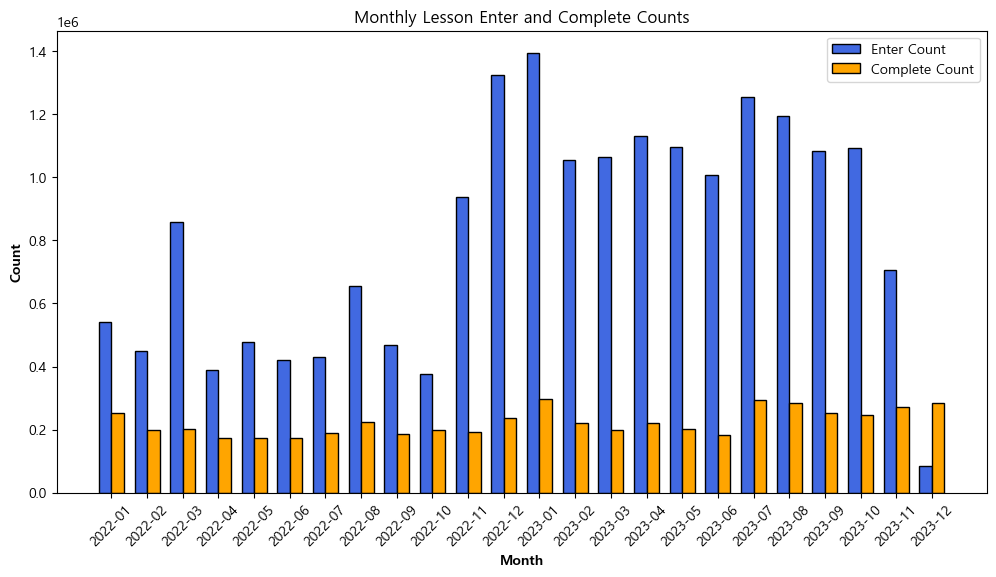

In [24]:
# 데이터프레임 병합
merged_df = pd.merge(monthly_users_enter_lesson, monthly_users_complete_lesson, on='month')

# 플롯그리기
fig, ax = plt.subplots(figsize=(12, 6))

# 바 넓이 설정
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(merged_df['month']))
r2 = [x + bar_width for x in r1]

# 바 그리기
ax.bar(r1, merged_df['enter_count'], color='royalblue', width=bar_width, edgecolor='black', label='Enter Count')
ax.bar(r2, merged_df['complete_count'], color='orange', width=bar_width, edgecolor='black', label='Complete Count')

# 라벨 붙이기
ax.set_xlabel('Month', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Monthly Lesson Enter and Complete Counts')
ax.set_xticks([r + bar_width/2 for r in range(len(merged_df['month']))])
ax.set_xticklabels(merged_df['month'], rotation=45)

# 레전드 붙이기
ax.legend()

# 그래프 그리기
plt.show()

In [25]:
# 할당 해제
del df_lesson_page, df_complete_lesson, monthly_users_enter_lesson, monthly_users_complete_lesson, merged_df

#### 완강율 그룹 확인해보기

In [26]:
# 데이터 셋 불러오기
df_lesson_page = datasets.enter.lesson_page()
df_complete_lesson = datasets.complete.lesson()

c:\Users\soom0\OneDrive\바탕 화면\정수민\코드잇\스프린트 미션\프로젝트 2\intermediate_project\intermediate_project\datasets.py:132: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [27]:
# lesson_id별로 count 계산
lesson_page_counts = df_lesson_page.groupby('lesson_id')['user_id'].size().reset_index(name='enter_count')
complete_lesson_counts = df_complete_lesson.groupby('lesson_id')['user_id'].size().reset_index(name='complete_count')

# Lesson_id별 Frequency 파악하기
merged_df = pd.merge(lesson_page_counts,complete_lesson_counts, on='lesson_id',how='outer')

In [28]:
print(merged_df.shape)
merged_df = merged_df.fillna(0)

# 0인 케이스에 대응하기 위해 분자와 분모에 1씩 더해서 나누기.
merged_df['complete/enter'] = round((merged_df['complete_count']+1) / (merged_df['enter_count']+1) * 100, 2)

(5488, 3)


complete/enter_group
0-10       317
10-20     1110
20-30      768
30-40     1249
40-50     1330
50-60      207
60-70       56
70-80       56
80-90       64
90-100      69
100+       262
Name: count, dtype: int64

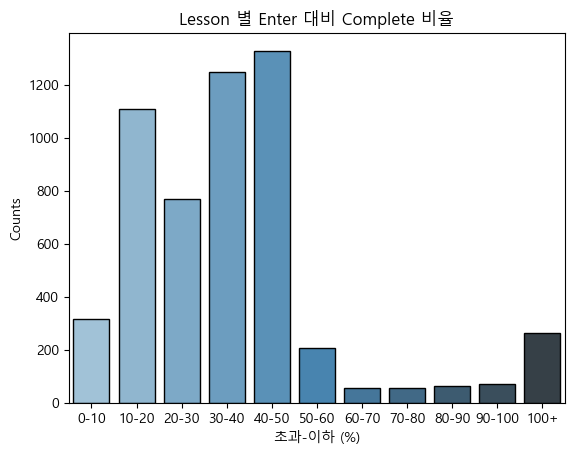

In [29]:
# complete/enter를 0~10, 10~20, ..., 100 이상으로 분할
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+']
merged_df['complete/enter_group'] = pd.cut(merged_df['complete/enter'], bins=bins, labels=labels, right=True)

# 각 그룹에 몇 개의 행들이 포함되어 있는지 count
group_counts = merged_df['complete/enter_group'].value_counts().sort_index()

# 결과 출력
display(group_counts)

# 바 그래프 그리기
sns.barplot(x=group_counts.index, y=group_counts.values, hue=group_counts.index, legend=False, palette='Blues_d', edgecolor='black')

plt.title("Lesson 별 Enter 대비 Complete 비율")
plt.ylabel("Counts")
plt.xlabel("초과-이하 (%)")
# 그래프 그리기
plt.show()

del group_counts

In [30]:
# 할당 해제
del df_lesson_page, df_complete_lesson, merged_df, lesson_page_counts, complete_lesson_counts

#### 컨텐츠 중심 살펴보기

In [31]:
# start.content와 end.content csv 파일 읽어오기
start_content = datasets.start.content()
end_content = datasets.end.content()

start_content = start_content[['user_id','content_id','event_type','client_event_time']]
end_content = end_content[['user_id','content_id','event_type','client_event_time']]

# user_id와 content_id를 기준으로 시작시간과 완료시간을 구하기
start_content['client_event_time'] = pd.to_datetime(start_content['client_event_time'])
end_content['client_event_time'] = pd.to_datetime(end_content['client_event_time'])

# 시작시간과 완료시간을 병합
merged_content = pd.merge(start_content, end_content, on=['user_id','content_id'], how='left', suffixes=('_start', '_end'))
merged_content = merged_content.sort_values(by=['user_id','client_event_time_start'])

# 결과 출력
display(merged_content.sort_values(by=['user_id','client_event_time_start']))

,user_id,content_id,event_type_start,client_event_time_start,event_type_end,client_event_time_end
40866,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,start.content,2023-03-19 00:45:24.384,NaN,NaT
7600,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,start.content,2023-03-19 01:49:45.361,end.content,2023-04-08 14:22:02.268
12559,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,start.content,2023-04-08 14:22:18.010,NaN,NaT
41304,000087537cbfd934375364218ff10f91,61b6463287573f00de13a930805a52d6,start.content,2023-03-27 14:14:11.273,NaN,NaT
6321,000087537cbfd934375364218ff10f91,445fac33232adcb3d1cdab7d8a579430,start.content,2023-04-01 20:43:07.425,NaN,NaT
...,...,...,...,...,...,...
6619,fffe529de03d6187ef7ed765650c8d2b,621c7ad99b17d2d16832b618d47aea7e,start.content,2023-06-12 07:51:57.794,NaN,NaT
68415,fffe529de03d6187ef7ed765650c8d2b,c269eb6df3a374b464f7c18f12fa398f,start.content,2023-08-07 13:13:59.462,end.content,2023-09-27 13:34:57.287
103907,fffe529de03d6187ef7ed765650c8d2b,f6f082e10dc9c1061cb809989b361d9c,start.content,2023-08-15 14:59:50.503,NaN,NaT
70245,fffe529de03d6187ef7ed765650c8d2b,e5007dcd8de20c69465c3aa6b5189a13,start.content,2023-10-02 14:31:16.033,end.content,2023-10-02 16:19:48.001


In [32]:
# 시간 차이 계산
try:
    merged_content['time_diff'] = merged_content['client_event_time_end'] - merged_content['client_event_time_start']
except:
    merged_content['time_diff'] = None

# 평균 컨텐츠 수료 시간
merged_content.time_diff.mean()

Timedelta('11 days 22:07:09.830171987')

In [33]:
merged_content.head(3)

,user_id,content_id,event_type_start,client_event_time_start,event_type_end,client_event_time_end,time_diff
40866,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,start.content,2023-03-19 00:45:24.384,NaN,NaT,NaT
7600,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,start.content,2023-03-19 01:49:45.361,end.content,2023-04-08 14:22:02.268,20 days 12:32:16.907000
12559,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,start.content,2023-04-08 14:22:18.010,NaN,NaT,NaT


In [34]:
# 다음 콘텐츠 시작 시간 계산
merged_content['next_start_time'] = merged_content.groupby('user_id')['client_event_time_start'].shift(-1)

# 콘텐츠 완료 시간과 다음 콘텐츠 시작 시간의 차이 계산
merged_content['time_to_next_start'] = merged_content['next_start_time'] - merged_content['client_event_time_end']

# 컨텐츠 완료 전에 다른 컨텐츠를 시작하는 경우를 제외하고자, 차이값을 0초과로 필터링
print("컨텐츠 수료후 다음 컨텐츠 시작까지의 평균 소요 기간")
print(merged_content.loc[merged_content['time_to_next_start'] > pd.Timedelta(0) ,'time_to_next_start'].mean())
merged_content.head(3)

컨텐츠 수료후 다음 컨텐츠 시작까지의 평균 소요 기간
3 days 13:31:27.803507565


,user_id,content_id,event_type_start,client_event_time_start,event_type_end,client_event_time_end,time_diff,next_start_time,time_to_next_start
40866,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,start.content,2023-03-19 00:45:24.384,NaN,NaT,NaT,2023-03-19 01:49:45.361,NaT
7600,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,start.content,2023-03-19 01:49:45.361,end.content,2023-04-08 14:22:02.268,20 days 12:32:16.907000,2023-04-08 14:22:18.010,0 days 00:00:15.742000
12559,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,start.content,2023-04-08 14:22:18.010,NaN,NaT,NaT,NaT,NaT


In [35]:
# 할당해제
del merged_content, start_content, end_content

#### 일자별로 본 complete_lesson

In [36]:
# 데이터 로드
complete_lesson = datasets.complete.lesson()

In [37]:
# 일자별 활성화(complete_lesson 기록이 존재하는) unique 유저의 수
complete_lesson['client_event_time'] = pd.to_datetime(complete_lesson['client_event_time'])
print(complete_lesson.resample('D', on='client_event_time')['user_id'].nunique())

client_event_time
2022-01-01    354
2022-01-02    511
2022-01-03    787
2022-01-04    780
2022-01-05    794
             ... 
2023-12-27    905
2023-12-28    993
2023-12-29    878
2023-12-30    808
2023-12-31    797
Freq: D, Name: user_id, Length: 730, dtype: int64


In [38]:
# 일자별 유저들이 수강하는 lesson의 수
complete_lesson['day'] = complete_lesson['client_event_time'].dt.strftime('%Y-%m-%d')
df = complete_lesson.groupby(['day','user_id'])['lesson_id'].nunique()
df.reset_index()

,day,user_id,lesson_id
0,2022-01-01,00b36040cd9f2a92f8cc5ac6badafbca,11
1,2022-01-01,0138b3600a07ff6576870669414223ae,8
2,2022-01-01,01bf4162685cae3c638fddbb30e29711,25
3,2022-01-01,02af2404029ab25593da0129163064d1,8
4,2022-01-01,0341258a32dff7193e121a1f05d0ba91,9
...,...,...,...
464545,2023-12-31,fe41f67d71cb9f20ecf541c62ded93f4,2
464546,2023-12-31,fe551a948c862c220158e34d3bc2bc47,3
464547,2023-12-31,fe5aadc78094de8a7d1d25ebf44229e6,3
464548,2023-12-31,ff899a7b6dda0e439e8f361177917ff2,5


In [39]:
# 각 일자별로 n개의 레슨을 들은 유저의 수
df2 = df.reset_index().groupby(['day','lesson_id'])['user_id'].nunique()
graph_data = df2.reset_index()
graph_data

,day,lesson_id,user_id
0,2022-01-01,1,37
1,2022-01-01,2,37
2,2022-01-01,3,25
3,2022-01-01,4,24
4,2022-01-01,5,24
...,...,...,...
43909,2023-12-31,118,1
43910,2023-12-31,127,1
43911,2023-12-31,128,1
43912,2023-12-31,159,1


          day  lesson_id  user_id lesson_id_bin
0  2022-01-01          1       37           1~2
1  2022-01-01          2       37           1~2
2  2022-01-01          3       25           3~4
3  2022-01-01          4       24           3~4
4  2022-01-01          5       24           5~6


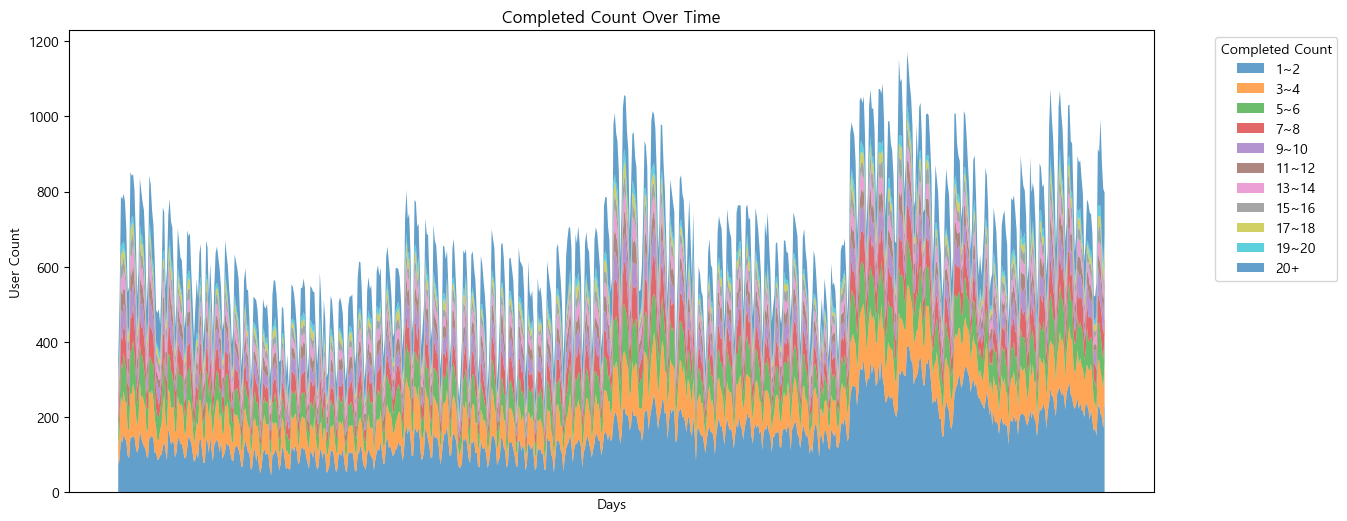

In [40]:
# lesson_id를 1부터 20, 20이상 총 11개의 bin으로 분할
bins = list(range(1, 22,2)) + [float('inf')]
labels = [f'{i}~{i+1}' for i in range(1, 20,2)] + ['20+']

graph_data['lesson_id_bin'] = pd.cut(graph_data['lesson_id'], bins=bins, labels=labels, right=False)

# 결과 출력
print(graph_data.head())

graph_data2 = graph_data.groupby(['day','lesson_id_bin'])['user_id'].sum().reset_index()
pivot_df = graph_data2.pivot(index='day', columns='lesson_id_bin', values='user_id').fillna(0)

plt.figure(figsize=(14, 6))
plt.stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.7)

plt.title('Completed Count Over Time')
plt.xlabel('Days')
plt.ylabel('User Count')
plt.legend(title='Completed Count')
plt.xticks([])
plt.legend(title='Completed Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

del graph_data2, pivot_df

In [41]:
# 할당 해제
del df, df2, graph_data, complete_lesson

#### Refferal

In [42]:
# 데이터 읽어오기
review = datasets.click.content_page_more_review_button()
start = datasets.start.content()

start['client_event_time'] = pd.to_datetime(start['client_event_time'])
start = start[['client_event_time','event_type','user_id','content_id']]
review['client_event_time'] = pd.to_datetime(review['client_event_time'])
review = review[['client_event_time','event_type','user_id','content_id']]

start.head(3)
review.head(3)

,client_event_time,event_type,user_id,content_id
0,2023-04-10 23:10:01.402,click.content_page_more_review_button,558fe7e8c06b8505f11b33d76f076e56,a1eeebeb6c307641b75b94a2a1d5b9aa
1,2023-01-25 06:37:43.417,click.content_page_more_review_button,e48956538e4df690a5d12adf1e6f2ee3,f491517f4737a60d661cd1fcacc702c0
2,2023-01-31 23:44:16.897,click.content_page_more_review_button,e745da89019e303b122bfceac0521a8f,9aa7628a347707fb155943041e2cb524


In [43]:
df = pd.concat([start,review],axis=0)
print("start한 컨텐츠 중, more _review를 본 유저와 컨텐츠 묶음")
display(df.groupby(['user_id','content_id'])['event_type'].nunique().value_counts())

start한 컨텐츠 중, more _review를 본 유저와 컨텐츠 묶음


event_type
1    127277
2       914
Name: count, dtype: int64

In [44]:
# user_id가 click_content_review를 했다면 1, content를 start했다면 1을 각각의 컬럼을 생성해서 기록. 하지 않았다면 0으로 기록

# click_content_review 여부를 기록하는 컬럼 생성
review['click_content_review'] = 1
start['start_content'] = 1

# user_id와 content_id를 기준으로 병합
df_combined = pd.merge(start, review, on=['user_id', 'content_id'], how='outer')

# 결측값을 0으로 채움
df_combined['click_content_review'] = df_combined['click_content_review'].fillna(0)
df_combined['start_content'] = df_combined['start_content'].fillna(0)
df_combined.dropna(subset=['user_id'], inplace=True)
# 결과 출력
df_combined[['user_id', 'content_id', 'click_content_review', 'start_content']]

,user_id,content_id,click_content_review,start_content
0,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,0.0,1.0
1,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,0.0,1.0
2,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,0.0,1.0
3,000087537cbfd934375364218ff10f91,0ab2b890d4068c1490b89676773256f6,0.0,1.0
4,000087537cbfd934375364218ff10f91,445fac33232adcb3d1cdab7d8a579430,0.0,1.0
...,...,...,...,...
134649,fffe529de03d6187ef7ed765650c8d2b,f491517f4737a60d661cd1fcacc702c0,0.0,1.0
134650,fffe529de03d6187ef7ed765650c8d2b,f4be1a0fe0e301b03115591777fddf29,0.0,1.0
134651,fffe529de03d6187ef7ed765650c8d2b,f6f082e10dc9c1061cb809989b361d9c,0.0,1.0
134652,fffe529de03d6187ef7ed765650c8d2b,f8b0ca043f5f0437603142ae93e6a424,0.0,1.0


In [45]:
# 독립변수: 컨텐츠 리뷰 보기
# 종속변수: 컨텐츠 시작하기
X = sm.add_constant(df_combined['click_content_review'])
y = df_combined['start_content']

# 로지스틱 회귀 모델 적합
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 출력
print(result.summary())
del logit_model, result, y, X

         Current function value: 0.025930
         Iterations: 35


c:\Users\soom0\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:          start_content   No. Observations:               134654
Model:                          Logit   Df Residuals:                   134652
Method:                           MLE   Df Model:                            1
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.8993
Time:                        11:39:42   Log-Likelihood:                -3491.6
converged:                      False   LL-Null:                       -34664.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   28.9411   5468.815      0.005      0.996   -1.07e+04    1.07e+04
click_content_review   -31.1321   5468.815     -0.006      0.995   -1.07e+04    1.07e+04

Possibly co

In [46]:
# 결과 해석
# 설명력은 0.9로 예측가능하지만, review를 클릭한 것의 상관계수는 -31로, review를 본 것과 오히려 음의 상관관계가 나타남.
# 이에 대한 해석으로, 듣고자 하는 다양한 컨텐츠들을 리뷰를 통해 살펴보는 사람은 있으나, 이 리뷰 진입이 잠재적인 흥미를 나타낼지언정 컨텐츠 시작과 긍적적으로 연결지어지지는 않는다는 것.
# 추가로 리뷰가 긍적적인 내용인지 부정적인 내용인지, 평점과 같은 세부 정보는 존재하지 않아서 추가 분석 진행은 어렵다고 판단.

In [47]:
del df_combined, start, review, df

### 메인 분석

#### 1. 콘텐츠 시작해놓고놓고 레슨 하나도 안듣고 컨텐츠 탓탓

In [48]:
# 데이터 불러오기
df_complete_signup = datasets.complete.signup()
df_start_content = datasets.start.content()
df_end_content = datasets.end.content()
df_complete_lesson = datasets.complete.lesson()
df_complete_subs = datasets.complete.subscription()
df_cancel = datasets.click.cancel_plan_button()

In [49]:
# 신규 회원 리스트
signup_list = df_complete_signup['user_id'].unique()

# 레슨 컴플릿 회원 리스트
complete_lesson_list = df_complete_lesson['user_id'].unique()

# 필요한 컬럼 설정, 신규 회원 한정 분석
df_start_content = df_start_content[['client_event_time','user_id','content_id','content_difficulty']]

# 신규회원 이면서, complete_lesson에 기록은 없는 유저
df_start_content = df_start_content.loc[(df_start_content['user_id'].isin(signup_list)) & (~df_start_content['user_id'].isin(complete_lesson_list))]

# 게으른 수강생 = 컨텐츠 시작 후 레슨 컴플릿이 없는 유저군
# 동시에 구독은 한 유저
lesson_lazy = df_start_content.user_id.unique()

# 게으른 수강생임과 동시에 구독을 했으나, 취소를 한 유저
lazy_paid_user = df_complete_subs.loc[df_complete_subs['user_id'].isin(lesson_lazy),'user_id'].unique()

# 취소도 안 한 유저
lazy_paid_user_notcanceled = df_cancel.loc[~df_cancel['user_id'].isin(lazy_paid_user),'user_id'].unique()


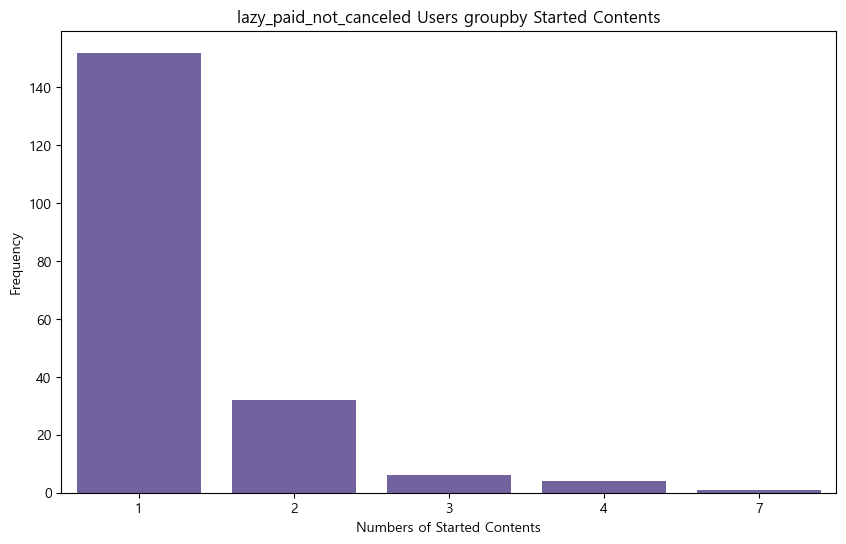

In [50]:

# 취소도 안 한 + 게으른 수강생들이 들은 컨텐츠의 수
graph = df_start_content.loc[df_start_content['user_id'].isin(lazy_paid_user_notcanceled)].groupby('user_id')['content_id'].nunique().sort_values()

# 그래프 데이터 준비
graph_data = graph.value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=graph_data.index, y=graph_data.values, color='#6e58a7')
plt.xlabel('Numbers of Started Contents')
plt.ylabel('Frequency')
plt.title('lazy_paid_not_canceled Users groupby Started Contents')
plt.show()

del graph_data

In [51]:
# 할당 해제
del df_complete_signup, df_complete_lesson, df_start_content, df_end_content, df_complete_subs, df_cancel

#### 2. 내가 나쁜게 아니라 콘텐츠가 나쁜거야!

1. 전체 유저군 대상 17만명    
2. 중복 기록에 대해서, 우선적으로 분 단위가 동일한 유저+컨텐츠 기록은 중복으로 판단하여 제거
3. 이탈률 정의 : 30일 이상 lesson_complete 가 안찍힌 유저

In [52]:
# 이탈율 계산하기
## complete_lesson 불러와서, 데이터 중복 처리 함수 수행
complete_lesson = datasets.complete.lesson()
complete_lesson = duplicated_data_processing(complete_lesson)

## complete lesson에서 각 user_id가 마지막으로 기록된 complete
last_completion_history = complete_lesson.sort_values(by='client_event_time').drop_duplicates(subset='user_id', keep='last')

last_completion_history['bounce_time'] = last_completion_history['client_event_time'] + pd.Timedelta(days=30)

## 이탈시점 (bounce_time)이 2024년 이후인 경우, 데이터 수집 범위상 이탈이라고 볼 수 없으므로, None으로 변경
last_completion_history.loc[last_completion_history['bounce_time'].dt.year == 2024,'bounce_time'] = None

lesson_id 대해서 초단위 중복 제거


In [53]:
start_content = datasets.start.content()
end_content = datasets.end.content()

start_content = duplicated_data_processing(start_content)
end_content = duplicated_data_processing(end_content)

content_id에 대해서 초단위 중복 제거
content_id에 대해서 초단위 중복 제거


In [54]:
# Start - End 연결
merged_df = pd.merge(
    start_content[['user_id','content_id','client_event_time','city']],
    end_content[['user_id','content_id','client_event_time','city']],
    on=['user_id','content_id'],
    how='left',
    suffixes=('_start','_end'),
    )
# 시간순으로 정렬
merged_df = merged_df.sort_values(['client_event_time_start','client_event_time_end'])

# end가 없는 경우만 필터링 (데이터 수 줄여서 작업하기)
not_end_content_df = merged_df.loc[merged_df['client_event_time_end'].isna()]

In [55]:
# not_end_content_df 와 complete_lesson을 연결
merged_df2 = pd.merge(
    not_end_content_df[['user_id','content_id','client_event_time_start']],
    complete_lesson[['user_id','content_id','lesson_id','client_event_time']],
    on=['user_id','content_id'],
    how='left',
    suffixes=('_content','_complete_lesson'))

# 시간순으로 정렬
merged_df2 = merged_df2.sort_values(['client_event_time_start','client_event_time'])

# 종료하지 않은 컨텐츠에 대해서 Lesson Complete 기록이 1개도 없는 컨텐츠를 가진 uesr_id
lazy_list = merged_df2.loc[merged_df2['lesson_id'].isna()].user_id.unique()

# 종료하지 않은 컨텐츠에 대해서 Lesson Complete 기록이 일부라도 있는 user_id
not_all_lazy = merged_df2.loc[(merged_df2['user_id'].isin(lazy_list)) & (~merged_df2['lesson_id'].isna())].user_id.unique()

# 종료하지 않은 모든 컨텐츠에 대해서 하나의 lesson complete도 없는 super_lazy

# 차집합 연산
super_lazy_list = np.setdiff1d(lazy_list, not_all_lazy)

In [56]:
print(f'''
종료하지 않은 컨텐츠에 대해서 Lesson Complete 기록이 1개도 없는 컨텐츠를 가진 uesr_id의 수 : {len(lazy_list)}
종료하지 않은 컨텐츠에 대해서 Lesson Complete 기록이 일부라도 있는 user_id의 수: {len(not_all_lazy)}
종료하지 않은 모든 컨텐츠에 대해서 하나의 lesson complete도 없는 user_id의 수: {len(super_lazy_list)}
''')


종료하지 않은 컨텐츠에 대해서 Lesson Complete 기록이 1개도 없는 컨텐츠를 가진 uesr_id의 수 : 15321
종료하지 않은 컨텐츠에 대해서 Lesson Complete 기록이 일부라도 있는 user_id의 수: 4982
종료하지 않은 모든 컨텐츠에 대해서 하나의 lesson complete도 없는 user_id의 수: 10339



In [57]:
# 시작하지 않은 레슨에 대한 complete 기록이 있을까?
complete_lesson.loc[complete_lesson['user_id'].isin(super_lazy_list)]

,city,client_event_time,country,device_family,device_type,event_type,language,os_name,user_id,content_id,lesson_id
3675035,Jung-gu,2022-01-01 09:00:01.181,South Korea,Mac,Mac,complete.lesson,Korean,Chrome,47c0c5284ff7f86a5ac16a3e6e07593b,afe201c04b426366e0f8e9e2207c78c2,3c8bd57fe0f9ad2ffc626459d1c49a12
3027803,Jung-gu,2022-01-01 10:17:51.086,South Korea,Mac,Mac,complete.lesson,Korean,Chrome,47c0c5284ff7f86a5ac16a3e6e07593b,afe201c04b426366e0f8e9e2207c78c2,dabfc3d9f23660a6d77e21421d3c10d5
2528718,Jung-gu,2022-01-01 11:21:57.191,South Korea,Mac,Mac,complete.lesson,Korean,Chrome,47c0c5284ff7f86a5ac16a3e6e07593b,e543c38ec7fa6bcd5045049ecc31e5f8,913b610ffdd068fb372859c3a40b7582
1879355,Jung-gu,2022-01-01 12:15:04.041,South Korea,Mac,Mac,complete.lesson,Korean,Chrome,47c0c5284ff7f86a5ac16a3e6e07593b,e543c38ec7fa6bcd5045049ecc31e5f8,3ffe84cf86eb1a1a8062694582b40eb7
1879374,Mokpo,2022-01-01 12:42:45.845,South Korea,Windows,Windows,complete.lesson,Korean,Chrome,ae3a1f50fd9e327592aa783dab688abc,f4be1a0fe0e301b03115591777fddf29,633d1b30ed699e261ea338ad28952338
...,...,...,...,...,...,...,...,...,...,...,...
5222192,NaN,2023-12-31 23:15:46.653,NaN,NaN,NaN,complete.lesson,NaN,NaN,78226be50aec4752f731620672ad5e30,f4be1a0fe0e301b03115591777fddf29,d6f17f978215b9746ea664d93c3f3d43
5222193,NaN,2023-12-31 23:16:25.737,NaN,NaN,NaN,complete.lesson,NaN,NaN,78226be50aec4752f731620672ad5e30,f4be1a0fe0e301b03115591777fddf29,9076881d7173085ad3967fc5236853cc
5222194,NaN,2023-12-31 23:21:19.908,NaN,NaN,NaN,complete.lesson,NaN,NaN,78226be50aec4752f731620672ad5e30,f4be1a0fe0e301b03115591777fddf29,23d6d66e597b8fb0a706fb0cd12234d6
5222195,NaN,2023-12-31 23:21:58.053,NaN,NaN,NaN,complete.lesson,NaN,NaN,78226be50aec4752f731620672ad5e30,f4be1a0fe0e301b03115591777fddf29,4b6cc370e587d711780ed4591634d443


In [58]:
## 이탈 시점 병합하기

merged_df3 = pd.merge(
    merged_df,
    last_completion_history[['user_id','bounce_time']],
    on='user_id',
    how='left',
    suffixes=('_complete_lesson','_last_completion'))

print(merged_df3.shape)
display(merged_df3.head(3))
merged_df3['time_diff'] = merged_df3['client_event_time_end'] - merged_df3['client_event_time_start']

# 유저 개개인의 컨텐츠 수료 기간 평균
merged_df3.groupby('content_id')['time_diff'].mean().sort_values().reset_index()


(124952, 7)


,user_id,content_id,client_event_time_start,city_start,client_event_time_end,city_end,bounce_time
0,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,Gwanak-gu,2022-08-18 16:00:41.457,Yongsan-gu,2023-12-27 15:27:24.206
1,c6138487987cd76c010ca0c9d172a84f,711579bdebbf6540613290ebc8fbd3fc,2022-08-17 16:12:14.374,NaN,2022-08-17 16:54:15.785,NaN,2022-09-16 16:54:15.720
2,0f62ee1034d8505f9e05fc3a1d7f04d2,ff7998135d650dbefb3f479c900cbcc7,2022-08-17 16:14:49.759,Seoul,2022-08-27 15:10:06.156,Seoul,NaT


,content_id,time_diff
0,16c90877db6d303e295cb27e74f55050,0 days 00:05:50.390000
1,7f3710876a1f7e774c5c39220bdb82d5,0 days 00:20:50.881000
2,fc6a9e04f693ea724c55153d1ae82c65,0 days 00:48:48.410000
3,6c1ab2ac2b70a203dad068301a9152a4,0 days 01:04:43.208021739
4,ed88bded4d552a42b70b65cf09e3943a,0 days 01:26:23.993250
...,...,...
146,ebd394bf186858e4b48ec05b539f7cc5,NaT
147,f131e2fc518ebc882b8ae4741e19b1f1,NaT
148,f51431e7311301cc311c3c572ecf2c1e,NaT
149,f6eddcdd83091c4ab623903786fe9c34,NaT


In [59]:
# 완료되지 못한 컨텐츠 중.. 이탈자의 마지막 컨텐츠인 경우
# 이 컨텐츠를 끝으로, 사람들이 많이 이탈한다?
test_df = merged_df3.loc[merged_df3['client_event_time_end'].isna()]
test_df = test_df.loc[test_df['client_event_time_start'] > (test_df['bounce_time'] - pd.Timedelta(days=31))]
test_df.groupby('content_id')['user_id'].nunique().sort_values(ascending=False).head(10)

content_id
f4be1a0fe0e301b03115591777fddf29    5551
61b6463287573f00de13a930805a52d6    3886
445fac33232adcb3d1cdab7d8a579430    1218
68a3658f1b936bfff3bd6960cd561b0a    1186
c269eb6df3a374b464f7c18f12fa398f     999
ca35d0138a7550f002f975310604a9b7     552
f491517f4737a60d661cd1fcacc702c0     456
595cb4bbfc83e683b0314ca1312cfbde     251
d6227ba76134f6cf821bb98b5f235bd0     248
b314d5aba64a0aab40602cb72a4a1504     217
Name: user_id, dtype: int64

In [60]:
# 할당 해제
del (
    test_df,
    merged_df3, merged_df2, merged_df,
    complete_lesson, start_content, end_content,
    not_end_content_df, last_completion_history, super_lazy_list, not_all_lazy, lazy_list, 
)

#### 3. 특정 시점에서의 이탈율...로 알아볼까?

In [61]:
# 데이터 로드 (사용자의 마지막 complete 기록 포함)
start_content = datasets.start.content()
end_content = datasets.end.content()
complete_lesson = datasets.complete.lesson()

start_content = duplicated_data_processing(start_content)
end_content = duplicated_data_processing(end_content)
complete_lesson = duplicated_data_processing(complete_lesson)

content_id에 대해서 초단위 중복 제거
content_id에 대해서 초단위 중복 제거
lesson_id 대해서 초단위 중복 제거


In [62]:
# start - end contents 병합
merged_df = pd.merge(
    start_content[['user_id','content_id','client_event_time']],
    end_content[['user_id','content_id','client_event_time']],
    on = ['user_id','content_id'],
    suffixes=('_start','_end'),
    how='left'
)
merged_df.head(3)

,user_id,content_id,client_event_time_start,client_event_time_end
0,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457
1,c6138487987cd76c010ca0c9d172a84f,711579bdebbf6540613290ebc8fbd3fc,2022-08-17 16:12:14.374,2022-08-17 16:54:15.785
2,0f62ee1034d8505f9e05fc3a1d7f04d2,ff7998135d650dbefb3f479c900cbcc7,2022-08-17 16:14:49.759,2022-08-27 15:10:06.156


In [63]:
# start_content가 8월 17일 이후 기록이므로, complete_lesson의 기록도 제한.
complete_lesson = complete_lesson.loc[complete_lesson['client_event_time'] >= '2022-08-17'].sort_values(by='client_event_time',ascending=True)

In [64]:
# start-end-complete
merged_df2 = pd.merge(
    merged_df,
    complete_lesson[['user_id','content_id','lesson_id','client_event_time']],
    on = ['user_id','content_id'],
    suffixes=('_content','_complete_lesson'),
    how = 'left'
)
merged_df2.head(3)

,user_id,content_id,client_event_time_start,client_event_time_end,lesson_id,client_event_time
0,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,2ed4b83e65edc2b1efb193aaa3c60cf9,2022-08-17 16:19:08.709
1,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,db421b66bfd27eccd0e862e30b4de1be,2022-08-17 16:25:48.483
2,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,09c8a2d29087cb3d47823acb5f2705e3,2022-08-17 16:30:17.033


In [65]:
merged_df2 = merged_df2.sort_values(by=['client_event_time_start','client_event_time_end'],ascending=True)

In [66]:
# merged_df2 전처리

# merged_df2['client_event_time'] = merged_df2['client_event_time'] - pd.Timedelta(seconds=1)

merged_df2['client_event_time_start'] = merged_df2['client_event_time_start'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged_df2['client_event_time_start'] = pd.to_datetime(merged_df2['client_event_time_start'])
merged_df2['client_event_time_end'] = merged_df2['client_event_time_end'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged_df2['client_event_time_end'] = pd.to_datetime(merged_df2['client_event_time_end'])
merged_df2['client_event_time'] = merged_df2['client_event_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
merged_df2['client_event_time'] = pd.to_datetime(merged_df2['client_event_time'])

In [67]:
# 아웃바운더리 여부 확인
merged_df2['is_outside_start_end'] = merged_df2.apply(
    lambda row: 1 if row['client_event_time'] < row['client_event_time_start'] or row['client_event_time'] > row['client_event_time_end'] else 0,
    axis=1
)

# 결과 확인
display(merged_df2[['user_id', 'content_id', 'client_event_time_start', 'client_event_time_end', 'client_event_time', 'is_outside_start_end']])

# 이상한 데이터 확인하기
merged_df2.loc[merged_df2.is_outside_start_end == 1].sort_values(['client_event_time_start','client_event_time_end','user_id','content_id'])

,user_id,content_id,client_event_time_start,client_event_time_end,client_event_time,is_outside_start_end
0,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12,2022-08-18 16:00:41,2022-08-17 16:19:08,0
1,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12,2022-08-18 16:00:41,2022-08-17 16:25:48,0
2,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12,2022-08-18 16:00:41,2022-08-17 16:30:17,0
3,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12,2022-08-18 16:00:41,2022-08-17 16:49:49,0
4,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12,2022-08-18 16:00:41,2022-08-17 17:03:20,0
...,...,...,...,...,...,...
2364291,8a01c8092d46749618e3d3a610a8825b,f4be1a0fe0e301b03115591777fddf29,2023-12-31 23:46:23,NaT,NaT,0
2364292,8a01c8092d46749618e3d3a610a8825b,f4be1a0fe0e301b03115591777fddf29,2023-12-31 23:47:09,NaT,NaT,0
2364294,926df494aebb5689996dacafaab0f00e,c8e53577758bf66711094352a5abd8c3,2023-12-31 23:51:43,NaT,2023-12-31 23:51:44,0
2364293,735f207da30919eafdb41672ffe60a7c,f64c475280676531a31f2f8e0648599c,2023-12-31 23:51:49,NaT,NaT,0


,user_id,content_id,client_event_time_start,client_event_time_end,lesson_id,client_event_time,is_outside_start_end
17,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12,2022-08-18 16:00:41,58a55a039ef52567cfe0821f92b3c9e6,2023-11-14 16:37:59,1
789,d2691bedf9ae0bc97a182e57361bdeb8,db43a841c994231e2795d4df8931af50,2022-08-17 18:23:59,2022-08-21 16:20:32,8e691fe79234147d56371958e02c095a,2022-08-21 16:23:22,1
790,d2691bedf9ae0bc97a182e57361bdeb8,db43a841c994231e2795d4df8931af50,2022-08-17 18:23:59,2022-08-21 16:20:32,8bc52caa371a1642b3c9024fb84eb3da,2022-08-21 16:23:40,1
791,d2691bedf9ae0bc97a182e57361bdeb8,db43a841c994231e2795d4df8931af50,2022-08-17 18:23:59,2022-08-21 16:20:32,b9a8a1bc33c25996244e5ba9b23f82d8,2022-08-21 16:24:09,1
792,d2691bedf9ae0bc97a182e57361bdeb8,db43a841c994231e2795d4df8931af50,2022-08-17 18:23:59,2022-08-21 16:20:32,17f09dbc78c010e2c151c29b4f802186,2022-08-21 16:25:37,1
...,...,...,...,...,...,...,...
2361567,310c7316dfc38f5c1cded37174d02e33,e88906bb19b773dcbf2adb5d34c49d9c,2023-12-31 01:49:54,2023-12-31 19:15:50,221c80203d4d08d248a9f2df5d7e4670,2023-12-31 19:15:51,1
2362093,f456d2560060e54231acd8f82bd6a31f,7102ec0223c06a3a14a7556274d86b7d,2023-12-31 11:26:16,2023-12-31 13:38:12,50319f76a58973d7a19c174f3f4a41e5,2023-12-31 11:26:15,1
2362419,8deb23021af4943a1832958e13b67030,a914987711c7e2db9fd4bff7555ec87c,2023-12-31 13:46:38,NaT,5a1ff0b618b1258b8a8d7671d8fa2957,2023-12-31 13:46:37,1
2362549,25bc8342d2c31ccbc22294d9171da0e4,ca35d0138a7550f002f975310604a9b7,2023-12-31 14:07:56,2023-12-31 15:56:48,1dfbb00cdb389d1cc93e16b0c815b74e,2023-12-31 15:56:49,1


In [68]:
# 유저가 컨텐츠 안에서 몇개의 레슨을 수강하는지 알아보기
display(merged_df2.groupby(['user_id','content_id'])['lesson_id'].nunique())

# 기간 내(2208~2312) 유저가 완료한 유니크 레슨 수
user_lesson_number = merged_df2.groupby(['user_id'])['lesson_id'].nunique()
user_lesson_number = user_lesson_number.reset_index().sort_values(by='lesson_id')
user_lesson_number

user_id                           content_id                      
0000572f2ba8079bcefd2760b632e820  61b6463287573f00de13a930805a52d6    11
                                  f491517f4737a60d661cd1fcacc702c0    17
                                  f4be1a0fe0e301b03115591777fddf29    15
000087537cbfd934375364218ff10f91  0ab2b890d4068c1490b89676773256f6     5
                                  445fac33232adcb3d1cdab7d8a579430     1
                                                                      ..
fffe529de03d6187ef7ed765650c8d2b  f491517f4737a60d661cd1fcacc702c0    44
                                  f4be1a0fe0e301b03115591777fddf29    15
                                  f6f082e10dc9c1061cb809989b361d9c     6
                                  f8b0ca043f5f0437603142ae93e6a424    13
ffffd8d78865a66cb3706977f29d1dec  f4be1a0fe0e301b03115591777fddf29     0
Name: lesson_id, Length: 124601, dtype: int64

,user_id,lesson_id
35540,d48c5ef938f7b502a74ea0c43178c2e7,0
33115,c6378245caf51b4cd39a86b389a2a50a,0
33109,c6273534deca087fdc06186d7d1fb34c,0
33108,c626a2c953c0da22595dfd41dd809e11,0
33105,c62304e69d8f9eccbb1a7df9b8e55f4b,0
...,...,...
16780,6421bf3808b89da97f316eac07da2b91,2531
6714,28068259a009cf16d0e19ae1896b1f22,2569
10829,40504dbd203dd148d1801171d04ceb5d,2708
34053,cc180eef3ffd3497eb8a575165bab389,3090


In [69]:
# 컴플릿 레슨 수로 본 각 그룹별 유저의 수
user_lesson_number.groupby('lesson_id')['user_id'].nunique()

lesson_id
0       9773
1       4280
2       2255
3       1548
4       1358
        ... 
2531       1
2569       1
2708       1
3090       1
3345       1
Name: user_id, Length: 988, dtype: int64

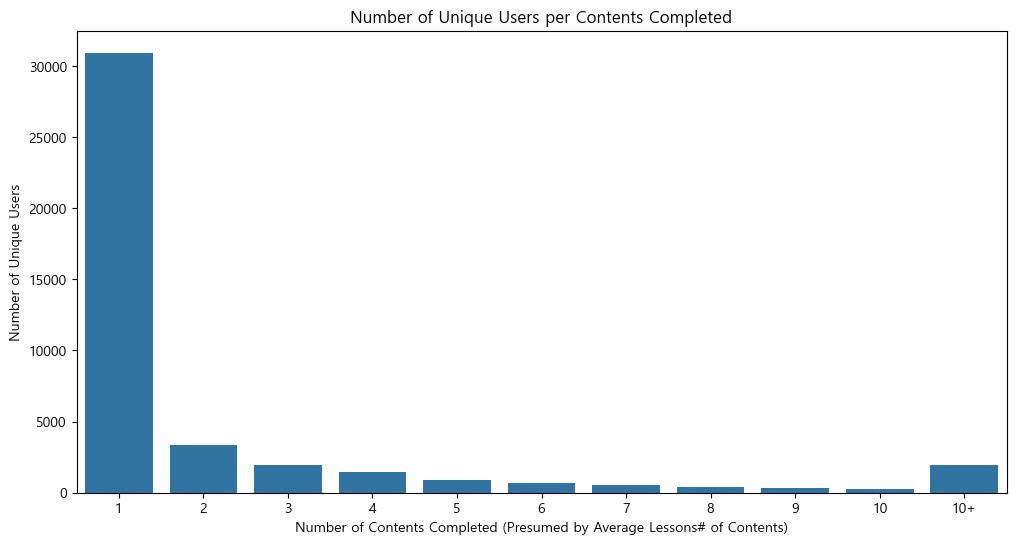

In [70]:
# 컴플릿 레슨 수로 본 각 그룹별 유저의 수 (그래프 데이터 준비)
lesson_user_counts = user_lesson_number.groupby('lesson_id')['user_id'].nunique()

# Cut the lesson_id into bins
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300,float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10','10+']
lesson_user_counts_binned = pd.cut(lesson_user_counts.index, bins=bins, labels=labels, right=False)
lesson_user_counts_binned = lesson_user_counts.groupby(lesson_user_counts_binned).sum()

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x=lesson_user_counts_binned.index, y=lesson_user_counts_binned.values)
plt.xlabel('Number of Contents Completed (Presumed by Average Lessons# of Contents)')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users per Contents Completed')
plt.show()

del (
    bins, labels,
    lesson_user_counts, lesson_user_counts_binned
)

In [71]:
# start_end_complete lesson 3개 재병합
merged_df3 = pd.merge(
    merged_df,
    complete_lesson[['user_id','lesson_id','client_event_time']],
    on = 'user_id',
    how='left'
)

# start 보다, complete이 이전에 존재하는 기록은 필터링ㅇ
merged_df3 = merged_df3[merged_df3['client_event_time_start'] <= merged_df3['client_event_time']]

# 컨텐츠 시작 시점으로 보는 이탈과, 레슨 컴플릿으로 보는 이탈 컬럼
merged_df3['start_bounce'] = merged_df3['client_event_time_start'] + pd.Timedelta(days=30)
merged_df3['complete_bounce'] = merged_df3['client_event_time'] + pd.Timedelta(days=30)

# 이탈을 의미하는 컬럼 추가
merged_df3['bounce'] = merged_df3.apply(
    lambda row: 1 if row['start_bounce'] > row['complete_bounce'] else 0,
    axis = 1
)
# 결과 확인
merged_df3.head(3)


,user_id,content_id,client_event_time_start,client_event_time_end,lesson_id,client_event_time,start_bounce,complete_bounce,bounce
0,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,2ed4b83e65edc2b1efb193aaa3c60cf9,2022-08-17 16:19:08.709,2022-09-16 16:11:12.230,2022-09-16 16:19:08.709,0
1,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,db421b66bfd27eccd0e862e30b4de1be,2022-08-17 16:25:48.483,2022-09-16 16:11:12.230,2022-09-16 16:25:48.483,0
2,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,09c8a2d29087cb3d47823acb5f2705e3,2022-08-17 16:30:17.033,2022-09-16 16:11:12.230,2022-09-16 16:30:17.033,0


In [72]:
# 각 유저의 start_content로 본 첫 활동 기록
start_timestamp = merged_df3.drop_duplicates(subset='user_id',keep='last')
end_timestamp = merged_df3.drop_duplicates(subset='user_id',keep='first')

# 해당 기록을 끝으로 이탈을 의미하는 is_end 컬럼 추가
start_timestamp['is_end'] = start_timestamp['client_event_time_end'].notnull().astype(int)
end_timestamp['is_end'] = end_timestamp['client_event_time_end'].notnull().astype(int)

# 결과 확인
start_timestamp.tail(5)
end_timestamp.tail(5)

C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\821483743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_timestamp['is_end'] = start_timestamp['client_event_time_end'].notnull().astype(int)
C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\821483743.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_timestamp['is_end'] = end_timestamp['client_event_time_end'].notnull().astype(int)


,user_id,content_id,client_event_time_start,client_event_time_end,lesson_id,client_event_time,start_bounce,complete_bounce,bounce,is_end
34985551,c7354a8816f21c639075a541ba168aa6,f4be1a0fe0e301b03115591777fddf29,2023-12-31 23:04:26.235,NaT,b42c9bb32f5024900cbed7623eecd272,2023-12-31 23:07:41.042,2024-01-30 23:04:26.235,2024-01-30 23:07:41.042,0,0
34987029,091efd61d0af03336955df82fc60fc30,f4be1a0fe0e301b03115591777fddf29,2023-12-31 23:09:28.778,NaT,b42c9bb32f5024900cbed7623eecd272,2023-12-31 23:09:51.422,2024-01-30 23:09:28.778,2024-01-30 23:09:51.422,0,0
34987124,c2f379460037197dd941fd1fc2fc87f4,61b6463287573f00de13a930805a52d6,2023-12-31 23:14:24.589,NaT,2ed4b83e65edc2b1efb193aaa3c60cf9,2023-12-31 23:33:43.030,2024-01-30 23:14:24.589,2024-01-30 23:33:43.030,0,0
34987127,1ff17f878a119da197d7d28ca5fe4aa6,61b6463287573f00de13a930805a52d6,2023-12-31 23:23:47.276,NaT,2ed4b83e65edc2b1efb193aaa3c60cf9,2023-12-31 23:23:48.107,2024-01-30 23:23:47.276,2024-01-30 23:23:48.107,0,0
34987144,783e01211e03edc828d55baf6e08a256,5de7fab2b23da75a5538040b92095165,2023-12-31 23:30:52.206,NaT,436273cc4d2984147eca045628a314a0,2023-12-31 23:30:52.500,2024-01-30 23:30:52.206,2024-01-30 23:30:52.500,0,0


In [73]:
#기간 내 각 유저의 첫 컨텐츠와 마지막 컨텐츠 시작 시간
merged_df4 = pd.merge(
    start_timestamp[['user_id','client_event_time_start','is_end']],
    end_timestamp[['user_id','content_id','client_event_time_start','is_end']],
    how = 'outer',
    on = ['user_id'],
    suffixes=('_first','_last')
)
merged_df4.rename(columns={'client_event_time_start_first': 'start_first', 'client_event_time_start_last' : 'start_last','content_id':'content_id_last'}, inplace=True)
merged_df4['time_diff'] = merged_df4['start_last'] - merged_df4['start_first']

# 결과 확인
merged_df4.head(5)

,user_id,start_first,is_end_first,content_id_last,start_last,is_end_last,time_diff
0,0000572f2ba8079bcefd2760b632e820,2023-04-08 14:22:18.010,0,61b6463287573f00de13a930805a52d6,2023-03-19 00:45:24.384,0,-21 days +10:23:06.374000
1,000087537cbfd934375364218ff10f91,2023-05-01 19:31:15.918,0,61b6463287573f00de13a930805a52d6,2023-03-27 14:14:11.273,0,-36 days +18:42:55.355000
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-30 11:35:37.133,0,f4be1a0fe0e301b03115591777fddf29,2023-11-22 21:50:00.941,1,-8 days +10:14:23.808000
3,0003b028a745bdfda9e88539424248af,2023-06-24 15:11:41.788,0,c269eb6df3a374b464f7c18f12fa398f,2023-06-24 15:11:41.788,0,0 days 00:00:00
4,000509014329002768958b9210789b4b,2023-09-15 02:24:18.795,0,61b6463287573f00de13a930805a52d6,2023-09-15 02:24:18.795,0,0 days 00:00:00


In [74]:
# last complete 기록 생성
sample_df = complete_lesson.sort_values(by='client_event_time',ascending=False).drop_duplicates(subset='user_id',keep='first')

# first_last content df와 last complete 기록 병합
merged_df5 = pd.merge(
    merged_df4,
    sample_df[['user_id','client_event_time']],
    on= 'user_id',
    how='left'
)
merged_df5.rename(columns={'client_event_time':'complete_last'},inplace=True)

# 최종적으로 이탈 여부를 확인
merged_df5['bounce_time'] = merged_df5['complete_last'] + pd.Timedelta(days=30)
merged_df5['bounce'] = merged_df5.apply(
    lambda row: 0 if row['bounce_time'].year == 2024 else 1,
    axis=1
)
# 결과 확인
merged_df5.head(5)

,user_id,start_first,is_end_first,content_id_last,start_last,is_end_last,time_diff,complete_last,bounce_time,bounce
0,0000572f2ba8079bcefd2760b632e820,2023-04-08 14:22:18.010,0,61b6463287573f00de13a930805a52d6,2023-03-19 00:45:24.384,0,-21 days +10:23:06.374000,2023-04-17 17:11:04.993,2023-05-17 17:11:04.993,1
1,000087537cbfd934375364218ff10f91,2023-05-01 19:31:15.918,0,61b6463287573f00de13a930805a52d6,2023-03-27 14:14:11.273,0,-36 days +18:42:55.355000,2023-05-01 20:18:27.781,2023-05-31 20:18:27.781,1
2,0001f15911b404f3bf5b8571afafa4e4,2023-11-30 11:35:37.133,0,f4be1a0fe0e301b03115591777fddf29,2023-11-22 21:50:00.941,1,-8 days +10:14:23.808000,2023-12-08 13:40:18.542,2024-01-07 13:40:18.542,0
3,0003b028a745bdfda9e88539424248af,2023-06-24 15:11:41.788,0,c269eb6df3a374b464f7c18f12fa398f,2023-06-24 15:11:41.788,0,0 days 00:00:00,2023-06-24 15:11:42.671,2023-07-24 15:11:42.671,1
4,000509014329002768958b9210789b4b,2023-09-15 02:24:18.795,0,61b6463287573f00de13a930805a52d6,2023-09-15 02:24:18.795,0,0 days 00:00:00,2023-09-15 02:24:19.380,2023-10-15 02:24:19.380,1


In [75]:
merged_df5.loc[merged_df5['bounce'] == 1,'time_diff'].mean()

Timedelta('-27 days +19:42:02.871095070')

In [76]:
# 할당 해제
del (
    merged_df5, merged_df4, merged_df3, merged_df2, merged_df,
    start_content, end_content, complete_lesson,
    sample_df, start_timestamp, end_timestamp, user_lesson_number
)

In [77]:
# 중단
# 이탈의 정의가 레슨 컴플릿 30일이 지나도록 더이상 기록되지 않는 경우라 정의했다.
# 이 경우, 컨텐츠 시작해놓고 레슨을 하나도 안들은 집단에 대한 분석과 정의적으로 겹치는 부분이 있다.
# 따라서 분석의 목표가 되는 " 이탈 위험군 파악 " 에는 도움이 되지 않는 접근방식이라 결정하고 방향을 바꾼다.

#### 4. 수강 중간 이탈 위험군 분석: start 한지 n일이 지나도록 end가 없는 유저 집단의 이탈률 비교

In [78]:
# 데이터 읽어오기
start_content = datasets.start.content()
end_content = datasets.end.content()
complete_lesson = datasets.complete.lesson()

start_content = duplicated_data_processing(start_content)
end_content = duplicated_data_processing(end_content)
complete_lesson = duplicated_data_processing(complete_lesson)

# 기간 설정
complete_lesson = complete_lesson.loc[complete_lesson['client_event_time'] >= '2022-08-17']
end_content = end_content.loc[end_content['client_event_time'] >= '2022-08-17']

content_id에 대해서 초단위 중복 제거
content_id에 대해서 초단위 중복 제거
lesson_id 대해서 초단위 중복 제거


In [79]:
# start_end 연결
merged_df = pd.merge(
    start_content[['user_id','content_id','client_event_time']],
    end_content[['user_id','content_id','client_event_time']],
    on = ['user_id','content_id'],
    how='left',
    suffixes=('_start','_end')
)
merged_df = merged_df.sort_values(by=['client_event_time_start','client_event_time_end','user_id','content_id'])

# 마지막 기록
last_completion_history = complete_lesson.sort_values(by='client_event_time',ascending=True).drop_duplicates(subset='user_id',keep='last')

# ※ NA 값을 채울것인가 말 것인가?
# merged_df['client_event_time_end'] = merged_df['client_event_time_end'].fillna('2024-01-01 00:00:00.000')

In [80]:
# start_end_last 기록 연결
merged_df2 = pd.merge(
    merged_df,
    last_completion_history[['user_id','content_id','client_event_time']],
    on=['user_id','content_id'],
    how='left'
)

# 컨텐츠 수료 기간 컬럼 추가
merged_df2['content_completion_period'] = merged_df2['client_event_time_end'] - merged_df2['client_event_time_start']

# 이탈 전 마지막 컨텐츠 판별 컬럼 초기화
merged_df2['is_last_content_before_bounce'] = 0

# 마지막 컴플리션 시간이 null이 아님 = 마지막임 = 이탈임
merged_df2.loc[merged_df2['client_event_time'].notnull(),'is_last_content_before_bounce'] = 1
merged_df2.loc[merged_df2['client_event_time_start'] > '2023-12-01','is_last_content_before_bounce'] = 0
merged_df2.drop(columns='client_event_time',inplace=True)

# 결과 
merged_df2.head(3)

,user_id,content_id,client_event_time_start,client_event_time_end,content_completion_period,is_last_content_before_bounce
0,9e50b5087acdbf4976aea376a0bca24c,61b6463287573f00de13a930805a52d6,2022-08-17 16:11:12.230,2022-08-18 16:00:41.457,0 days 23:49:29.227000,0
1,c6138487987cd76c010ca0c9d172a84f,711579bdebbf6540613290ebc8fbd3fc,2022-08-17 16:12:14.374,2022-08-17 16:54:15.785,0 days 00:42:01.411000,1
2,0f62ee1034d8505f9e05fc3a1d7f04d2,ff7998135d650dbefb3f479c900cbcc7,2022-08-17 16:14:49.759,2022-08-27 15:10:06.156,9 days 22:55:16.397000,0


In [81]:
unique_user_merged_df2 = merged_df2.groupby('user_id')[['content_completion_period','is_last_content_before_bounce']].mean().reset_index()
unique_user_merged_df2.head(3)

# bounce의 수치는, 그사람이 들은 이탈하기 전까지의 content의 개수를 역산할 수 있는 정보. 이를 0 과 1로 통일하는 코드
# unique_user_merged_df2.loc[unique_user_merged_df2['is_last_content_before_bounce'] > 0,'is_last_content_before_bounce'] = 1

,user_id,content_completion_period,is_last_content_before_bounce
0,0000572f2ba8079bcefd2760b632e820,20 days 12:32:16.907000,0.333333
1,000087537cbfd934375364218ff10f91,NaT,0.333333
2,0001f15911b404f3bf5b8571afafa4e4,3 days 18:47:54.410000,0.333333


In [82]:
unique_user_merged_df2['number_of_start_contents'] = np.where(
    unique_user_merged_df2['is_last_content_before_bounce'] == 0, np.nan,
    round(1 / unique_user_merged_df2['is_last_content_before_bounce'], 0)
)

# 이탈 전 까지 평균 start하는 컨텐츠의 수
print(unique_user_merged_df2.number_of_start_contents.mean())

3.4357218124341413


In [83]:
# 해당 컨텐츠를 끝으로 이탈한 경우 중, 컨텐츠를 수료한 경우의 비율
total_count = merged_df2.loc[merged_df2['is_last_content_before_bounce'] == 1].shape[0]
null_end_count = merged_df2.loc[merged_df2['is_last_content_before_bounce'] == 1,'content_completion_period'].isna().sum()
not_null_end_count = total_count - null_end_count

# 해당 컨텐츠를 마무리 하지 않은 케이스 중, 그것이 마지막인 경우의 비율
total_not_end_count = merged_df2.loc[merged_df2['content_completion_period'].isna()].shape[0]
not_end_bounce_count = merged_df2.loc[(merged_df2['content_completion_period'].isna()) & (merged_df2['is_last_content_before_bounce'] == 1)].shape[0]
not_end_but_not_bounce_count = total_not_end_count - not_end_bounce_count

# 완료 후 이탈한 경우의 비율
total_end_count = merged_df2.loc[~merged_df2['content_completion_period'].isna()].shape[0]
end_bounce_count = merged_df2.loc[(~merged_df2['content_completion_period'].isna()) & (merged_df2['is_last_content_before_bounce'] == 1)].shape[0]

# 컨텐츠 수강 start 경우에서 컨텐츠 수강 전후로 이탈한 비율
total_count_duration0 = merged_df2.shape[0]
bounce_count_duration0 = merged_df2.loc[merged_df2['is_last_content_before_bounce']==1].shape[0]

# content_completion_period가 7일 이상인 경우
duration1 = merged_df2.loc[(merged_df2['content_completion_period'] > '7days') | (merged_df2['content_completion_period'].isna())]
total_count_duration1 = duration1.shape[0]
bounce_count_duration1 = duration1.loc[duration1['is_last_content_before_bounce']==1].shape[0]
del duration1

# content_completion_period가 14일 이상인 경우
duration2 = merged_df2.loc[(merged_df2['content_completion_period'] > '14days') | (merged_df2['content_completion_period'].isna())]
total_count_duration2 = duration2.shape[0]
bounce_count_duration2 = duration2.loc[duration2['is_last_content_before_bounce']==1].shape[0]
del duration2

# content_completion_period가 30일 이상인 경우
duration3 = merged_df2.loc[(merged_df2['content_completion_period'] > '30days') | (merged_df2['content_completion_period'].isna())]
total_count_duration3 = duration3.shape[0]
bounce_count_duration3 = duration3.loc[duration3['is_last_content_before_bounce']==1].shape[0]

print(f'''
특정 컨텐츠를 끝으로 이탈한 경우 중, 해당 컨텐츠를 수료하지 않은 경우의 비율 : {null_end_count/total_count*100:.2f}%    
특정 컨텐츠를 마무리 하지 않은 경우 가운데, 해당 컨텐츠를 끝으로 이탈한 경우의 비율 : {not_end_bounce_count/total_not_end_count*100:.2f}%
특정 컨텐츠를 완료한 경우 중, 이탈한 비율 : { end_bounce_count / total_end_count*100:.2f}%

전체 기간에서 이탈한 경우 비율 : {bounce_count_duration0 / total_count_duration0*100:.2f}%
Duration1 에서 이탈한 경우 비율 : {bounce_count_duration1 / total_count_duration1*100:.2f}%
Duration2 에서 이탈한 경우 비율 : {bounce_count_duration2 / total_count_duration2*100:.2f}%
Duration3 에서 이탈한 경우 비율 : {bounce_count_duration3 / total_count_duration3*100:.2f}%
''')

# 할당 해제
del (
    bounce_count_duration0, bounce_count_duration1, bounce_count_duration3, bounce_count_duration2,
    total_count_duration0, total_count_duration1, total_count_duration2, total_count_duration3,
    total_count, null_end_count, not_null_end_count,
    total_not_end_count, not_end_but_not_bounce_count, not_end_bounce_count
)


특정 컨텐츠를 끝으로 이탈한 경우 중, 해당 컨텐츠를 수료하지 않은 경우의 비율 : 86.27%    
특정 컨텐츠를 마무리 하지 않은 경우 가운데, 해당 컨텐츠를 끝으로 이탈한 경우의 비율 : 31.31%
특정 컨텐츠를 완료한 경우 중, 이탈한 비율 : 7.06%

전체 기간에서 이탈한 경우 비율 : 21.28%
Duration1 에서 이탈한 경우 비율 : 26.99%
Duration2 에서 이탈한 경우 비율 : 28.60%
Duration3 에서 이탈한 경우 비율 : 29.88%



#### 5. 가설 설정 및 검정해보기 (단일 회귀 분석)

H0: 컨텐츠 진행 기간은 이탈과 관련이 없다.    
Ha: 컨텐츠 진행 기간은 이탈과 관련이 있다.

In [84]:
merged_df2.content_completion_period.mean()

Timedelta('12 days 03:16:15.690160114')

In [85]:
# data 설정.
data = merged_df2[['content_completion_period','is_last_content_before_bounce']]
# data = complete_lesson_df[['learning_cycle','bounce']]
# data.rename(columns={'bounce':'is_last_content_before_bounce','learning_cycle':'content_completion_period'},inplace=True)
# null 제외
data = data.dropna()
data['content_completion_period'] = data['content_completion_period'].dt.total_seconds() / 3600  # 초를 시간으로 변환, 평균 11일 이므로, 시간 단위가 적절할 것으로 생각.


# 독립변수에 상수 추가 (절편 포함)
X = sm.add_constant(data['content_completion_period'])
y = data['is_last_content_before_bounce']


# 로지스틱 회귀 모델 적합
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 출력
print(result.summary())

# 오즈 비 계산 (해석을 위해 exp 변환)
print(f"Odds Ratio: {np.exp(result.params)}")

# 할당해제
del data, X, y, logit_model, result

Optimization terminated successfully.
         Current function value: 0.255147
         Iterations 6
                                 Logit Regression Results                                
Dep. Variable:     is_last_content_before_bounce   No. Observations:                51688
Model:                                     Logit   Df Residuals:                    51686
Method:                                      MLE   Df Model:                            1
Date:                           Wed, 12 Mar 2025   Pseudo R-squ.:               0.0001278
Time:                                   11:44:53   Log-Likelihood:                -13188.
converged:                                  True   LL-Null:                       -13190.
Covariance Type:                       nonrobust   LLR p-value:                   0.06635
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [86]:
# 적절한 회귀 모델 구성 실패. 다른 검증 방법 사용
# 한 명의 유저가 여러번의 기간을 가질 수 있으나, 이탈 자체는 한번만 이루어진다는 점을 감안하여 로지스틱 회귀분석의 결과가 부정확할 가능성을 제기한다.
# 이 부분으로 인한 데이터의 분포차가 클 것으로 예상, Cox 분석으로 진행해본다.

In [87]:
# pip install lifelines

In [88]:
from lifelines import CoxPHFitter

# 샘플 데이터 (유저별 기간과 이탈 여부)
data = merged_df2[['content_completion_period','is_last_content_before_bounce']]
# null 제외
data = data.dropna()
data['content_completion_period'] = data['content_completion_period'].dt.total_seconds() / 3600  # 초를 시간으로 변환, 평균 11일 이므로, 시간 단위가 적절할 것으로 생

# Cox 생존 분석 모델
cph = CoxPHFitter()
cph.fit(data, duration_col='content_completion_period', event_col='is_last_content_before_bounce')
cph.print_summary()  # 결과 출력

# 할당 해제
del data, cph

<lifelines.CoxPHFitter: fitted with 51688 total observations, 48039 right-censored observations>
             duration col = 'content_completion_period'
                event col = 'is_last_content_before_bounce'
      baseline estimation = breslow
   number of observations = 51688
number of events observed = 3649
   partial log-likelihood = -36414.85
         time fit was run = 2025-03-12 02:44:54 UTC

---
Empty DataFrame
Columns: [ coef,  exp(coef),  se(coef),  coef lower 95%,  coef upper 95%,  exp(coef) lower 95%,  exp(coef) upper 95%]
Index: []

Empty DataFrame
Columns: [ cmp to,  z,  p,  -log2(p)]
Index: []
---
Concordance = 0.50
Partial AIC = 72829.70
log-likelihood ratio test = 0.00 on 0 df
-log2(p) of ll-ratio test = nan

In [89]:
# Concordance 0.5, Partial AIC 72829. 무작위에 가까운 배열로, 예측성능이 전무한 것으로 보여짐.
# 이러한 결과를 바탕으로 두 변수간 상관관계가 없을 가능성이 높은것으로 추정.
# 'is_last_content_before_bounce' 가 이산된 범주형 데이터이므로, 피어슨 상관분석은 적절하지 않음.
# 포인트-바이서리얼 상관분석으로 진행

In [90]:
from scipy.stats import pointbiserialr

# 데이터 설정
data = merged_df2[['content_completion_period','is_last_content_before_bounce']]
# null 제외
data = data.dropna()
data['content_completion_period'] = data['content_completion_period'].dt.total_seconds() / 3600  # 초를 시간으로 변환, 평균 11일 이므로, 시간 단위가 적절할 것으로 생각

# 포인트-바이서리얼 상관계수 계산
corr, p_value = pointbiserialr(data['content_completion_period'], data['is_last_content_before_bounce'])

# 결과 출력
print(f"포인트-바이서리얼 상관계수: {corr:.4f}")
print(f"p-value: {p_value:.4f}")

# 할당 해제
del data, corr, p_value

포인트-바이서리얼 상관계수: -0.0079
p-value: 0.0727


In [91]:
# 상관계수가 -0.0079 이므로, 무관계하거나, 적절한 데이터를 확보한다면 이 두 변수간 약한 음의 상관이 나타날 수도 있음.
# p-value가 0.0727로, p-value 상으로 통계적으로 유의하지 않음.

#### 6. 이탈이 많은 컨텐츠 ?

In [92]:
# 각 컨텐츠를 끝으로 이탈하는 평균 유저의 수
print(merged_df2.groupby('content_id')['is_last_content_before_bounce'].sum().sort_values(ascending=False).mean())

# 해당 컨텐츠를 끝으로 이탈하는 유저의 수가 많은 컨텐츠
print(merged_df2.groupby('content_id')['is_last_content_before_bounce'].sum().sort_values(ascending=False).head(10))

merged_df2.groupby('content_id')['is_last_content_before_bounce'].sum().sort_values(ascending=False).reset_index()


176.03973509933775
content_id
f4be1a0fe0e301b03115591777fddf29    7577
61b6463287573f00de13a930805a52d6    4262
68a3658f1b936bfff3bd6960cd561b0a    1617
445fac33232adcb3d1cdab7d8a579430    1496
c269eb6df3a374b464f7c18f12fa398f    1446
f491517f4737a60d661cd1fcacc702c0    1327
ca35d0138a7550f002f975310604a9b7     689
595cb4bbfc83e683b0314ca1312cfbde     678
b314d5aba64a0aab40602cb72a4a1504     455
db1819d3a7a4c4d85dccb3b9e982fbcd     406
Name: is_last_content_before_bounce, dtype: int64


,content_id,is_last_content_before_bounce
0,f4be1a0fe0e301b03115591777fddf29,7577
1,61b6463287573f00de13a930805a52d6,4262
2,68a3658f1b936bfff3bd6960cd561b0a,1617
3,445fac33232adcb3d1cdab7d8a579430,1496
4,c269eb6df3a374b464f7c18f12fa398f,1446
...,...,...
146,f131e2fc518ebc882b8ae4741e19b1f1,0
147,ed88bded4d552a42b70b65cf09e3943a,0
148,f6eddcdd83091c4ab623903786fe9c34,0
149,f8aff0ae05422945bf20e1e49d832826,0


In [93]:
# 이탈을 많이 하는 컨텐츠(count)와 이탈 마려운 컨텐츠(비율)
merged_df3 = pd.merge(
    merged_df2.groupby('content_id')['user_id'].nunique().sort_values(ascending=False).reset_index(),
    merged_df2.groupby('content_id')['is_last_content_before_bounce'].sum().sort_values(ascending=False).reset_index(),
    on = 'content_id',
    how='left',
    suffixes=('_total','_bounce')
)
merged_df3.rename(columns={'user_id':'total_counts','is_last_content_before_bounce':'bounce_count'},inplace=True)
merged_df3['ratio'] = round(merged_df3['bounce_count'] / merged_df3['total_counts'] * 100,2)
merged_df3.loc[merged_df3['total_counts'] > 10].sort_values(by='ratio',ascending=False)

,content_id,total_counts,bounce_count,ratio
6,c269eb6df3a374b464f7c18f12fa398f,3439,1446,42.05
4,445fac33232adcb3d1cdab7d8a579430,4696,1496,31.86
10,ca35d0138a7550f002f975310604a9b7,2164,689,31.84
93,db82104b9c508953b3d00eea82844a48,69,21,30.43
0,f4be1a0fe0e301b03115591777fddf29,24982,7577,30.33
...,...,...,...,...
102,c7a97d9b71626d5115e2bcdadfe4dd48,35,1,2.86
98,2b5356626c7f28ead91ea99f6bb3d349,52,1,1.92
92,9982f3f4fcaf73515a5474c68c6a218a,98,0,0.00
99,19ea0db437b56a32040ea4e47b11fc82,49,0,0.00


In [94]:
# 상위 10개 컨텐츠 id 추출
head10 = merged_df2.groupby('content_id')['is_last_content_before_bounce'].sum().sort_values(ascending=False).reset_index().head(10).content_id.unique()
merged_df3.loc[merged_df3['content_id'].isin(head10)]

,content_id,total_counts,bounce_count,ratio
0,f4be1a0fe0e301b03115591777fddf29,24982,7577,30.33
1,61b6463287573f00de13a930805a52d6,15184,4262,28.07
2,f491517f4737a60d661cd1fcacc702c0,5607,1327,23.67
3,68a3658f1b936bfff3bd6960cd561b0a,5555,1617,29.11
4,445fac33232adcb3d1cdab7d8a579430,4696,1496,31.86
5,595cb4bbfc83e683b0314ca1312cfbde,4130,678,16.42
6,c269eb6df3a374b464f7c18f12fa398f,3439,1446,42.05
7,b314d5aba64a0aab40602cb72a4a1504,2974,455,15.30
9,db1819d3a7a4c4d85dccb3b9e982fbcd,2412,406,16.83
10,ca35d0138a7550f002f975310604a9b7,2164,689,31.84


In [95]:
# 난이도와 병합
merged_df4 = pd.merge(
    merged_df3,
    start_content[['content_id','content_difficulty']],
    on = 'content_id',
    how='left'
)
print(merged_df4.shape[0])
# 머지중 발생한 중복 제거
merged_df4 = merged_df4.drop_duplicates()
print(merged_df4.shape[0])

# 10명 이상이 수강한 컨텐츠 기록만 사용
merged_df4 = merged_df4.loc[merged_df4['total_counts']>=10].sort_values(by=['ratio','content_id'],ascending=False)
print(merged_df4.shape[0])

124751
168
126


In [96]:
# 난이도를 숫자로 치환
dic = {
'beginner':1,
'intermediate':2,
'advanced':3,
'hard':4
}
merged_df4['content_difficulty'] = merged_df4['content_difficulty'].map(dic)
merged_df4.groupby('content_id').mean().reset_index()

,content_id,total_counts,bounce_count,ratio,content_difficulty
0,03b4a290c08f7fa83933827a994f2e61,459.0,32.0,6.97,3.0
1,0ab2b890d4068c1490b89676773256f6,1458.0,227.0,15.57,2.0
2,101e1d0dcc38d9c86156f008a145083e,941.0,175.0,18.60,2.5
3,123715e9b63b3efb32cdcd947ea96aaf,212.0,26.0,12.26,2.0
4,165def8885b8a2ec0c92404048d7e345,336.0,34.0,10.12,2.0
...,...,...,...,...,...
104,f64c475280676531a31f2f8e0648599c,1323.0,149.0,11.26,2.0
105,f6f082e10dc9c1061cb809989b361d9c,450.0,51.0,11.33,2.0
106,f8b0ca043f5f0437603142ae93e6a424,370.0,42.0,11.35,2.0
107,fc3051206e08a57bc14fa52a7eec904b,11.0,2.0,18.18,2.0


In [97]:
# 난이도 별 이탈 비율
sample_df = merged_df4.groupby('content_id').mean().reset_index().groupby('content_difficulty')[['total_counts','bounce_count']].sum()
sample_df['ratio'] = round(sample_df['bounce_count'] / sample_df['total_counts'] * 100 ,2)
sample_df

,total_counts,bounce_count,ratio
content_difficulty,,,
1.0,53755.0,14669.0,27.29
1.5,4696.0,1496.0,31.86
2.0,34255.0,5262.0,15.36
2.5,4881.0,616.0,12.62
3.0,23645.0,4084.0,17.27
3.5,1547.0,191.0,12.35
4.0,1720.0,254.0,14.77


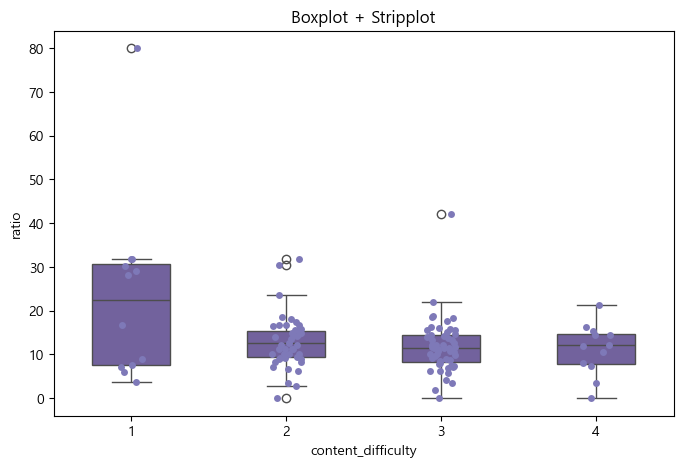

In [98]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="content_difficulty", y="ratio", data=merged_df4, width=0.5,color='#6e58a7')
sns.stripplot(x="content_difficulty", y="ratio", data=merged_df4, color='#7e79b8', jitter=True)
plt.title("Boxplot + Stripplot")
plt.show()


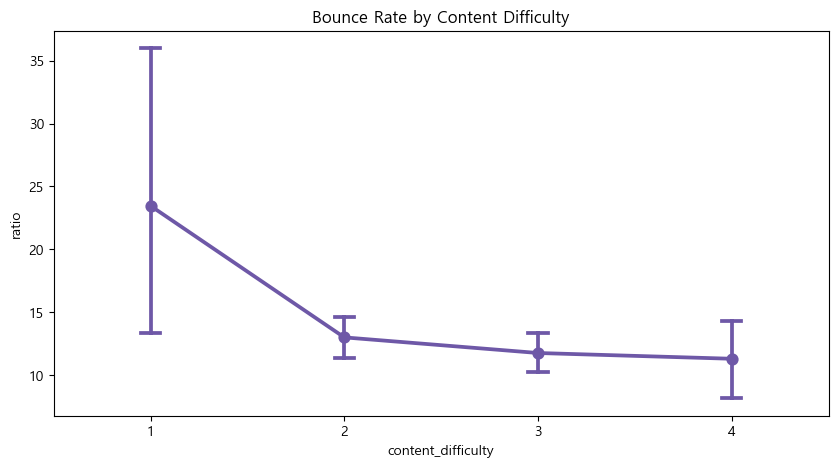

In [99]:
plt.figure(figsize=(10, 5))
sns.pointplot(x=merged_df4.content_difficulty, y=merged_df4['ratio'], ci=95, capsize=0.1, markers="o",color='#6e58a7')
plt.title("Bounce Rate by Content Difficulty")
plt.show()


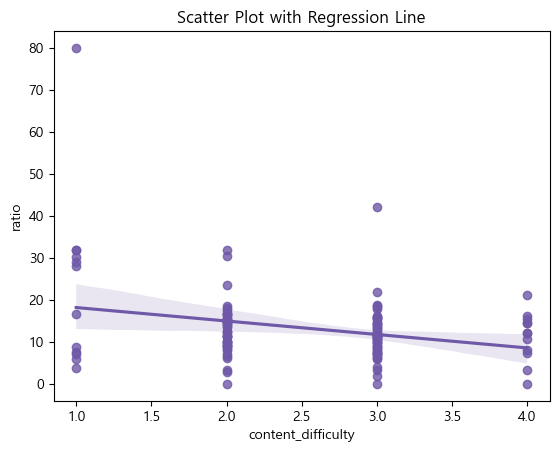

In [100]:
sns.regplot(x=merged_df4.content_difficulty, y=merged_df4['ratio'], color='#6e58a7')
plt.title("Scatter Plot with Regression Line")
plt.show()

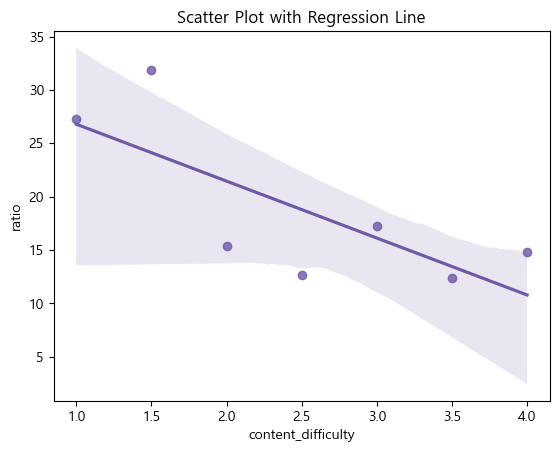

In [101]:
sns.regplot(x=sample_df.index, y=sample_df['ratio'], color='#6e58a7')
plt.title("Scatter Plot with Regression Line")
plt.show()

In [102]:
from scipy.stats import pearsonr

# 피어슨 상관계수 (선형 관계)
pearson_corr, pearson_p = pearsonr(merged_df4.ratio, merged_df4.content_difficulty)

print(f"📌 피어슨 상관계수: {pearson_corr:.4f}, p-value: {pearson_p:.8f}")

del pearson_corr, pearson_p

📌 피어슨 상관계수: -0.2816, p-value: 0.00140070


In [103]:
# 피어슨 상관계수 (선형 관계)
pearson_corr, pearson_p = pearsonr(sample_df['ratio'], sample_df.index)

print(f"📌 피어슨 상관계수: {pearson_corr:.4f}, p-value: {pearson_p:.8f}")

del pearson_corr, pearson_p

📌 피어슨 상관계수: -0.7512, p-value: 0.05158137


In [104]:
# 수료한 사람이 100명이 넘은 컨텐츠에 대해서, 난이도와 이탈 간의 상관관계를 파악해 본 결과
# 아주 약한 음의 상관관계가 나타나는 것으로 보여짐. p-value 역시 유의수준 아래에 위치.
# 다시 말해 난이도가 낮은 컨텐츠에서 이탈이 더 자주 목격된다고 볼 수 있음.

In [105]:
# 4~6 데이터 할당 해제
del (
    start_content, end_content, complete_lesson,
    merged_df, merged_df2, merged_df3, merged_df4, unique_user_merged_df2,
    sample_df, head10
)

#### 7. 복귀 유저 포함 bounce

In [119]:
# complete_lesson 기록만 사용하여 유저 활동 기록 확인하기로 결정

# 데이터 로드
complete_lesson = datasets.complete.lesson()
complete_lesson = duplicated_data_processing(complete_lesson)

# 사용하는 컬럼
complete_lesson_df = complete_lesson[['user_id','content_id','lesson_id','client_event_time']]

# 일단위로 분리
complete_lesson_df['client_event_time'] = complete_lesson_df['client_event_time'].dt.strftime('%Y-%m-%d')

lesson_id 대해서 초단위 중복 제거


C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\2556013472.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_lesson_df['client_event_time'] = complete_lesson_df['client_event_time'].dt.strftime('%Y-%m-%d')


In [120]:
# 일 단위 기록은 압축, 다음 lesson complete 기록 컬럼을 추가
complete_lesson_df = complete_lesson_df.sort_values('client_event_time').drop_duplicates(subset=['user_id','content_id','client_event_time'],keep='last').sort_values(['user_id','client_event_time'])
complete_lesson_df['next_complete_time'] = complete_lesson_df.groupby('user_id')['client_event_time'].shift(-1)

# 결과 확인
complete_lesson_df.head(8)


,user_id,content_id,lesson_id,client_event_time,next_complete_time
222221,0000572f2ba8079bcefd2760b632e820,61b6463287573f00de13a930805a52d6,1e2a48ce24bce72e7d36da219ee9d254,2023-03-19,2023-03-19
222230,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,7be65151a4b1cf91d7ca93b1e2b9ec69,2023-03-19,2023-03-20
1061080,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,02968d35dacf2041e4067dc87d9798a2,2023-03-20,2023-04-08
368297,0000572f2ba8079bcefd2760b632e820,f4be1a0fe0e301b03115591777fddf29,9076881d7173085ad3967fc5236853cc,2023-04-08,2023-04-10
54577,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,1f999ddf3da23ac236e6c74f1fb71c92,2023-04-10,2023-04-11
310578,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,e3c9b82c5f10d44c97626fa9ed166537,2023-04-11,2023-04-13
766615,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,3ab5e48c9976ca9cfb90c0d69c62e10e,2023-04-13,2023-04-17
193524,0000572f2ba8079bcefd2760b632e820,f491517f4737a60d661cd1fcacc702c0,ad01992e03e1be73ccf9f400ddac598a,2023-04-17,NaN


In [121]:
complete_lesson_df['client_event_time'] = pd.to_datetime(complete_lesson_df['client_event_time'])
complete_lesson_df['next_complete_time'] = pd.to_datetime(complete_lesson_df['next_complete_time'])

# 다음 컴플릿 기록이 없는 경우는 2024-01-01의 값을 임의로 부여
complete_lesson_df['next_complete_time'] = complete_lesson_df['next_complete_time'].fillna('2024-01-01')

# 다음 컴플릿 기록과 30일 이상 차이나는 경우 'bounce' : 이탈로 정의
complete_lesson_df['bounce'] = complete_lesson_df.apply(
    lambda row: 1 if (row['next_complete_time'] - row['client_event_time']).days > 30 else 0,
    axis=1
)

# complete_lesson day별 주기
complete_lesson_df['learning_cycle'] = complete_lesson_df['next_complete_time'] - complete_lesson_df['client_event_time']

# 예상 bounce 시점이 24년으로 넘어가는 경우 = 23-12-01 이후 컴플릿 기록건에 대해서는, 이탈하지 않음으로 처리
complete_lesson_df.loc[complete_lesson_df['client_event_time'] > '2023-12-01','bounce'] = 0

# learning_cycle 에서, 이탈한 경우 -30days 를 통해, cycle의 의미가 학습 주기 or 휴식 기간을 의미하도록 변경
complete_lesson_df.loc[complete_lesson_df['bounce'] == 1,'learning_cycle'] -= pd.Timedelta(days=30)

In [122]:
# # 조건

# 데이터 범위 밖 케이스
cd1 = complete_lesson_df['next_complete_time'] < '2024-01-01'

# 기간 제한 조건 (7일 미만)
cd2 = complete_lesson_df['learning_cycle'] <= '7 days'

In [123]:
# 분석용 데이터 프레임 생성.

sample_df = complete_lesson_df.loc[(complete_lesson_df['bounce']==0)].groupby('user_id')[['learning_cycle','bounce']].agg({
    'learning_cycle' :['count','sum']})

temp_df = complete_lesson_df.groupby('user_id')[['bounce']].agg({
    'bounce' : ['sum']
})

sample_df = pd.merge(
    sample_df,
    temp_df,
    on = 'user_id',
    how='left',
    suffixes=('_learnging_cycle','_bounce')
)

del temp_df
display(sample_df.head(8))
display(sample_df.mean())

learning_cycle          bounce
                                          count      sum    sum
user_id                                                        
0000572f2ba8079bcefd2760b632e820              7  29 days      1
000087537cbfd934375364218ff10f91              3  35 days      1
0001f15911b404f3bf5b8571afafa4e4             13  40 days      0
0003c0ede663b9e3b55d9dc3f7e8690f             39 118 days      1
000722d5152d121ef57d8246dff4ac91             18  43 days      1
000773425ea95bf12501964471e230ba              6  20 days      1
0008fe653493aa211bc7bd217bc0725c              8  19 days      1
000ae43430184824318d11fcd3ae8b45             15  23 days      1

learning_cycle  count                     14.185198
                sum      35 days 04:07:40.352089858
bounce          sum                        1.260935
dtype: object

,user_id,learning_cycle_count,learning_cycle_sum,bounce
0,47c0c5284ff7f86a5ac16a3e6e07593b,11.0,31 days,2
1,c6991cc646bce25351e3a64ea00ccb1f,60.0,114 days,3
2,8b4603c99dbd3ec51f40fa2d8e9d9c28,20.0,28 days,4
3,0464280c37522b57bc889e05ac52ae56,10.0,58 days,2
4,2c38dd9ece918c2c4ca432768431e0d8,40.0,172 days,4
...,...,...,...,...
49665,091efd61d0af03336955df82fc60fc30,1.0,1 days,0
49666,1ff17f878a119da197d7d28ca5fe4aa6,1.0,1 days,0
49667,783e01211e03edc828d55baf6e08a256,1.0,1 days,0
49668,c2f379460037197dd941fd1fc2fc87f4,1.0,1 days,0


C:\Users\soom0\AppData\Local\Temp\ipykernel_18336\2181542493.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bounce_avg_learning_cycle = temp_df.reset_index().groupby('bounce').apply(


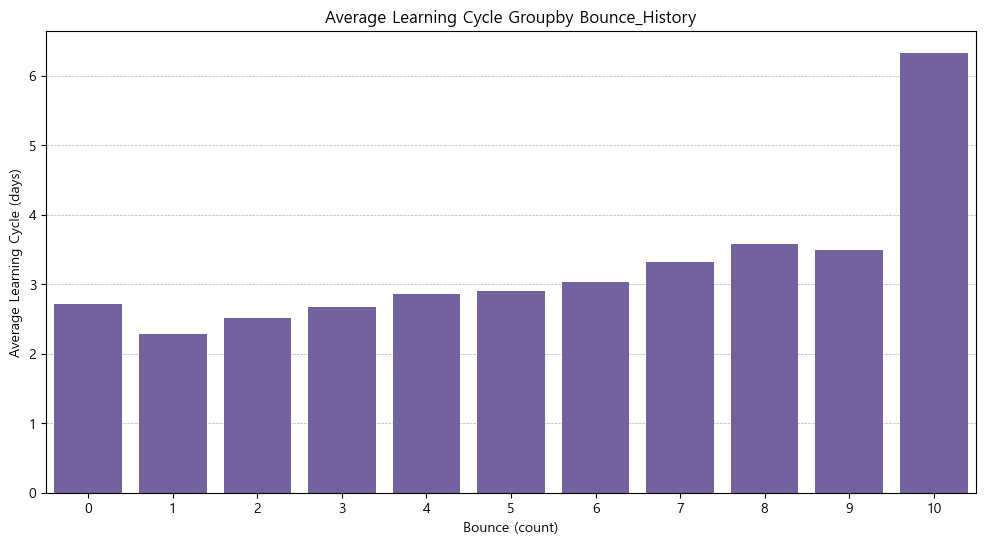

In [129]:
# # 이탈 횟수 그룹에 따른 평균 학습(활성화) 주기

# 각 row를 유저별로 unique하게 만들어서, 유저의 서비스 이용 특징을 파악

temp_df = complete_lesson['user_id'].drop_duplicates()
temp_df = pd.merge(
    temp_df,
    complete_lesson_df.loc[(complete_lesson_df['bounce']==0)].groupby('user_id')['learning_cycle'].count(),
    on = 'user_id',
    how='left'
)

temp_df = pd.merge(
    temp_df,
    complete_lesson_df.loc[(complete_lesson_df['bounce']==0)].groupby('user_id')['learning_cycle'].sum(),
    on = 'user_id',
    how='left',
    suffixes=('_count','_sum')
)

temp_df = pd.merge(
    temp_df,
    complete_lesson_df.groupby('user_id')['bounce'].sum(),
    on = 'user_id',
    how='left'
)
display(temp_df)

# timedelta -> int 형변환
try:
    temp_df['learning_cycle_sum'] = temp_df.learning_cycle_sum.dt.days
except:
    pass


# 그래프용 데이터 정제
bounce_avg_learning_cycle = temp_df.reset_index().groupby('bounce').apply(
    lambda x: x['learning_cycle_sum'].sum() / x['learning_cycle_count'].sum()
)

# 플랏
plt.figure(figsize=(12, 6))
sns.barplot(x=bounce_avg_learning_cycle.index, y=bounce_avg_learning_cycle.values,color='#6e58a7')

#축 라벨링
plt.xlabel('Bounce (count)')
plt.ylabel('Average Learning Cycle (days)')
plt.title('Average Learning Cycle Groupby Bounce_History')

# 격자선 추가
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.gca().set_axisbelow(True)
plt.show()

del temp_df, bounce_avg_learning_cycle

In [112]:
# 이탈하지 않고, 학습 주기 기간 제한 조건 (7일 이하)

sample_df = complete_lesson_df.loc[(complete_lesson_df['bounce']==0) & (cd2)].groupby('user_id')[['learning_cycle','bounce']].agg({
    'learning_cycle' :['count','mean']})

temp_df = complete_lesson_df.groupby('user_id')[['bounce']].agg({
    'bounce' : ['sum']
})

sample_df = pd.merge(
    sample_df,
    temp_df,
    on = 'user_id',
    how='left',
    suffixes=('_learnging_cycle','_bounce')
)

del temp_df

display(sample_df)

# 이탈에 도달하기 까지 평균 공부 days, 공부 간격, 평균 이탈
display(sample_df.mean())

learning_cycle                            \
                                          count                      mean   
user_id                                                                     
0000572f2ba8079bcefd2760b632e820              6           1 days 16:00:00   
000087537cbfd934375364218ff10f91              2           4 days 12:00:00   
0001f15911b404f3bf5b8571afafa4e4             12           1 days 08:00:00   
0003c0ede663b9e3b55d9dc3f7e8690f             36           2 days 02:40:00   
000722d5152d121ef57d8246dff4ac91             17 1 days 19:45:52.941176470   
...                                         ...                       ...   
fffadab35ddc8234e1c5139815bfc017             22 1 days 02:10:54.545454545   
fffba676b17f9f0f228360930f238f07              1           1 days 00:00:00   
fffcae39952c396123f9a3c0808a2183             13 0 days 16:36:55.384615384   
fffcbf8ded60b689e9867bff455f4ab7              3           1 days 16:00:00   
fffe529de03d6187ef7ed765650c8d2b             56 1 days 05:08:34.285714285   

                                 bounce  
                                    sum  
user_id                                  
0000572f2ba8079bcefd2760b632e820      1  
000087537cbfd934375364218ff10f91      1  
0001f15911b404f3bf5b8571afafa4e4      0  
0003c0ede663b9e3b55d9dc3f7e8690f      1  
000722d5152d121ef57d8246dff4ac91      1  
...                                 ...  
fffadab35ddc8234e1c5139815bfc017      1  
fffba676b17f9f0f228360930f238f07      1  
fffcae39952c396123f9a3c0808a2183      1  
fffcbf8ded60b689e9867bff455f4ab7      1  
fffe529de03d6187ef7ed765650c8d2b      2  

[34705 rows x 3 columns]

learning_cycle  count                    13.966028
                mean     1 days 13:06:02.288746243
bounce          sum                       1.320473
dtype: object

In [ ]:
# 학습 주기를  [ ] 로 보았을 때의 결과
for i in [3, 7, 14, 21, 30] :
    cd2 = complete_lesson_df['learning_cycle'] <= f'{i} days'
    sample_df = complete_lesson_df.loc[(complete_lesson_df['bounce']==0) & (cd2)].groupby('user_id')[['learning_cycle','bounce']].agg({
    'learning_cycle' :['count','mean']})

    temp_df = complete_lesson_df.groupby('user_id')[['bounce']].agg({
        'bounce' : ['sum']
    })

    sample_df = pd.merge(
        sample_df,
        temp_df,
        on = 'user_id',
        how='left',
        suffixes=('_learnging_cycle','_bounce')
    )

    del temp_df
    sample_df.loc[:, ('learning_cycle', 'count')] += sample_df.loc[:, ('bounce', 'sum')]
    # sample_df.loc[:, ('bounce', 'sum')] = sample_df.loc[:, ('bounce', 'sum')].astype(float)
    # sample_df.loc[:, ('bounce', 'sum')] += 0.1
    print(f'\n learning cycle이 {i}day 이하인 케이스에 대하여 ')
    display(sample_df.mean())


 learning cycle이 3day 이하인 케이스에 대하여 


learning_cycle  count                    14.163594
                mean     0 days 22:35:41.463247311
bounce          sum                       1.336733
dtype: object


 learning cycle이 7day 이하인 케이스에 대하여 


learning_cycle  count                    15.286501
                mean     1 days 13:06:02.288746243
bounce          sum                       1.320473
dtype: object


 learning cycle이 14day 이하인 케이스에 대하여 


learning_cycle  count                    15.595856
                mean     2 days 05:54:38.799357689
bounce          sum                       1.301189
dtype: object


 learning cycle이 21day 이하인 케이스에 대하여 


learning_cycle  count                    15.594008
                mean     2 days 20:59:38.474856480
bounce          sum                       1.285241
dtype: object


 learning cycle이 30day 이하인 케이스에 대하여 


learning_cycle  count                    15.446133
                mean     3 days 19:03:50.297207179
bounce          sum                       1.260935
dtype: object

In [114]:
# 결과 해석 (전체 미 이탈 기간에 대해여)
# 유저마다 평균 learning_cycle count days 정도 공부한다.
# 유저가 공부- 다음 공부간의 평균 공부 간격은 learnig_cycle mean 정도이다.
# bounce_sum은 잘못 만든 데이터 프레임으로 결과 해석에서 제외한다.


# learning_cycle이 14일 이하인 집단에서 가장 높은 평균 learning_cycle count days를 기록한다. (3~7일 보다는 상승하고, 14일 이후로는 하락한다.)
# learning_cycle이 늘어질수록, 복귀율이 하락한다.
# learning_cycle이 늘어질수록, 평균 공부 간격이 길어진다.

# 소결론. complete lesson 이후 14일이 지날수록, 서비스 지속 이용에 대한 지표가 감소한다.

In [149]:
# 러닝 사이클이 n days 인 그룹으로 유저를 분할하여 분석.

# 이탈 하지 않았으면서, 23년 12월 기록은 현황 파악이 불가하므로 분석에서 제외
temp_df = complete_lesson_df.loc[(complete_lesson_df['bounce']==0) & (cd1)]
temp_df.groupby('user_id')['learning_cycle'].count()
temp_df.groupby('user_id')['learning_cycle'].mean()

merged_df = pd.merge(
    temp_df.groupby('user_id')['learning_cycle'].count(),
    temp_df.groupby('user_id')['learning_cycle'].mean(),
    on='user_id',
    suffixes=('_count','_mean')
)
merged_df = pd.merge(
    merged_df,
    complete_lesson_df.groupby('user_id')['bounce'].sum(),
    on='user_id'
)
merged_df

,learning_cycle_count,learning_cycle_mean,bounce
user_id,,,
0000572f2ba8079bcefd2760b632e820,7,4 days 03:25:42.857142857,1
000087537cbfd934375364218ff10f91,3,11 days 16:00:00,1
0001f15911b404f3bf5b8571afafa4e4,12,1 days 08:00:00,0
0003c0ede663b9e3b55d9dc3f7e8690f,39,3 days 00:36:55.384615384,1
000722d5152d121ef57d8246dff4ac91,18,2 days 09:20:00,1
...,...,...,...
fffadab35ddc8234e1c5139815bfc017,22,1 days 02:10:54.545454545,1
fffba676b17f9f0f228360930f238f07,1,1 days 00:00:00,1
fffcae39952c396123f9a3c0808a2183,14,1 days 05:08:34.285714285,1


In [ ]:
# 그룹 분할
bins = [0, 3, 7, 14, 21, 30]
labels = ['0~3 days', '4~7 days', '8~14 days', '15~21 days', '22~30 days']

# 해당 그룹 정보 컬럼 추가
merged_df['learning_cycle_group'] = pd.cut(merged_df['learning_cycle_mean'].dt.days, bins=bins, labels=labels, right=True)

# 결과 확인
display(merged_df.head(5))

del bins, labels

,learning_cycle_count,learning_cycle_mean,bounce,learning_cycle_group
user_id,,,,
0000572f2ba8079bcefd2760b632e820,7,4 days 03:25:42.857142857,1,4~7 days
000087537cbfd934375364218ff10f91,3,11 days 16:00:00,1,8~14 days
0001f15911b404f3bf5b8571afafa4e4,12,1 days 08:00:00,0,0~3 days
0003c0ede663b9e3b55d9dc3f7e8690f,39,3 days 00:36:55.384615384,1,0~3 days
000722d5152d121ef57d8246dff4ac91,18,2 days 09:20:00,1,0~3 days


In [151]:
merged_df.groupby('learning_cycle_group')[['learning_cycle_count','learning_cycle_mean','bounce']].mean()

,learning_cycle_count,learning_cycle_mean,bounce
learning_cycle_group,,,
0~3 days,18.388848,2 days 01:55:22.022802097,1.380929
4~7 days,9.390665,5 days 06:55:48.325089186,1.503269
8~14 days,3.543872,10 days 07:16:22.097374533,1.319797
15~21 days,1.447099,17 days 16:10:51.194539249,1.160410
22~30 days,1.091603,25 days 18:13:44.427480916,1.114504


In [153]:
merged_df.loc[merged_df['learning_cycle_group']=='22~30 days']

,learning_cycle_count,learning_cycle_mean,bounce,learning_cycle_group
user_id,,,,
01e0a54f46ed6e2bdf71b520558d45db,1,24 days,1,22~30 days
060a38c5dee2b2871c8308163264b115,1,27 days,1,22~30 days
06e2f5c2e10ab6a919abbfe83f6f63f9,1,27 days,1,22~30 days
08c1bcb43faa173f9a1ef679fa621eb3,1,27 days,1,22~30 days
0a0f4789ad1922f6ca7fb500ae9fa9da,1,27 days,2,22~30 days
...,...,...,...,...
fa4808f4a3868a8736b688a71629af98,1,25 days,1,22~30 days
fa58177660c687803ee14ac44f3d5cae,1,27 days,1,22~30 days
fc5de3b99a236a570cbc50f11298f080,1,25 days,1,22~30 days


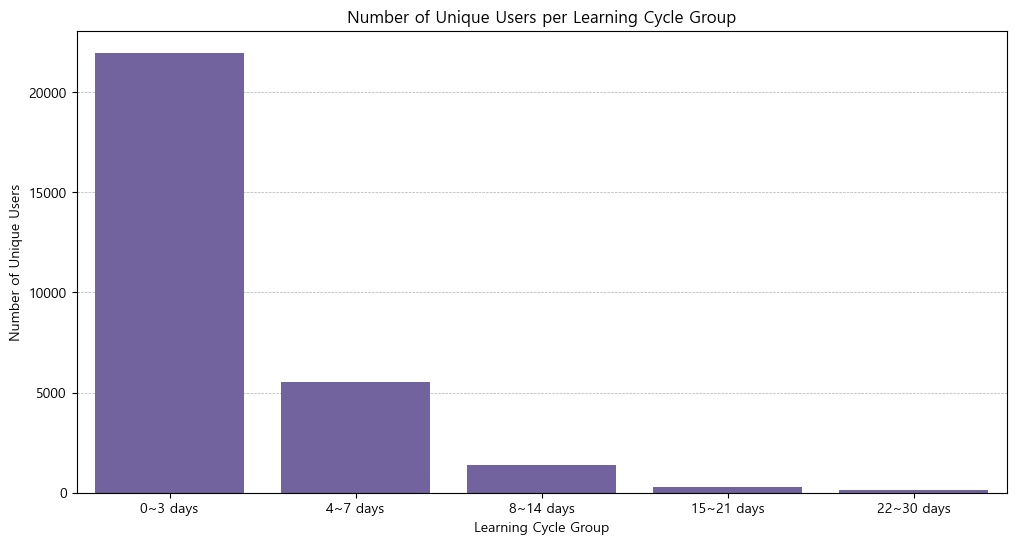

In [155]:

# 유저 수 세기
grouped_df = merged_df.groupby('learning_cycle_group').size()

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_df.index, y=grouped_df.values,color='#6e58a7')
plt.xlabel('Learning Cycle Group')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users per Learning Cycle Group')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
plt.gca().set_axisbelow(True)
plt.show()

# 할당 해제
del grouped_df

In [156]:
# 목적 : 이탈 전까지 공부하는 평균 day와 이탈간의 관계성

# X,Y 설정. X = 공부한 일자  Y = 이탈하는 횟수
X = sample_df['learning_cycle']['count'] + sample_df['bounce']['sum']
y = sample_df['bounce']['sum']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

del X, y, model

                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4648.
Date:                Wed, 12 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:02:47   Log-Likelihood:                -49193.
No. Observations:               37036   AIC:                         9.839e+04
Df Residuals:                   37034   BIC:                         9.841e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0293      0.006    176.355      0.0

In [117]:
# 해석 불가

In [118]:
# 할당 해제
del complete_lesson, cd1, cd2, complete_lesson_df, sample_df